# Import libraries

In [750]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import scipy.stats as stats
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, levene, pearsonr
from statsmodels.stats.power import TTestIndPower
from sklearn.model_selection import train_test_split
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import StandardScaler , RobustScaler , PowerTransformer, QuantileTransformer

#preprocesing
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import joblib



In [751]:
#warnings fix
warnings.filterwarnings("ignore", category=UserWarning, module="IPython")
plt.rcParams['font.family'] = 'DejaVu Sans'  # Change the font globally
plt.tight_layout()  # Ensure layout adjustments

<Figure size 640x480 with 0 Axes>

# Load datasets

In [752]:
patient_df = pd.read_csv('132/patient.csv', sep = '\t')
station_df = pd.read_csv('132/station.csv', sep= '\t')
observation_df = pd.read_csv('132/observation.csv', sep = '\t')

In [753]:
patient_df.head()

,company,current_location,ssn,name,mail,user_id,residence,username,birthdate,address,registration,blood_group,station_ID
0,小林農林合同会社,"(Decimal('32.168477'), Decimal('9.804478'))",302-73-9054,清水 英樹,takuma47@gmail.com,1770,NaN,snakajima,1937-03-07,岩手県多摩市二つ室27丁目2番7号,2020-08-15,B-,464
1,"Gray, Cunningham and Morales","(Decimal('-80.289857'), Decimal('2.308813'))",499-92-6793,Nicholas Campbell,curtis06@yahoo.com,946,NaN,benjamin02,1993-05-15,"0515 Angela Run\r\nPort Thomasberg, GU 35535",2018-11-30,A-,109
2,Walter,"(Decimal('63.5169555'), Decimal('-48.876252'))",925-81-9055,Raissa Rose,junkgisbert@yahoo.de,2010,NaN,jkoehler,NaN,Louise-Stey-Platz 79\r\n88420 Bremervörde,"05/09/2025, 00:00:00",O-,462
3,有限会社遠藤銀行,"(Decimal('-71.015803'), Decimal('140.978474'))",175-19-6965,後藤 知実,morimomoko@gmail.com,1100,NaN,yamaguchikana,2000-08-20,岡山県横浜市青葉区西小来川26丁目5番4号 南郷屋コーポ985,"10/21/2022, 00:00:00",B-,191
4,Munari s.r.l.,"(Decimal('-58.1525245'), Decimal('-120.099037'))",FRSMRL26C50L167Z,Eraldo Anguillara,bpergolesi@poste.it,1247,NaN,guglielmomicheletti,NaN,NaN,2024-11-26,B+,588


In [754]:
station_df.head()

,QoS,code,latitude,revision,longitude,station
0,good,JP,36.00000,2020-11-25,139.55722,Okegawa
1,excellent,IN,11.93381,"05/24/2021, 00:00:00",79.82979,Puducherry
2,maintenance,DE,52.21099,2022-05-10,7.02238,Gronau
3,excellent,CN,41.09822,2018-01-23,120.74792,Nanpiao
4,good,US,33.54428,08 Jun 2024,-84.23381,Stockbridge


In [755]:
observation_df.head()

,SpO₂,HR,PI,RR,EtCO₂,FiO₂,PRV,BP,Skin Temperature,Motion/Activity index,...,CO,Blood Flow Index,PPG waveform features,Signal Quality Index,Respiratory effort,O₂ extraction ratio,SNR,oximetry,latitude,longitude
0,97.538229,87.194745,11.225419,14.812012,42.113735,33.852538,144.504405,100.455727,35.961920,10.302567,...,4.022852,58.317397,49.143701,42.399816,46.497869,0.289012,39.334620,1.0,49.183239,15.454273
1,97.933271,80.787303,11.730935,14.964972,39.537692,65.326035,110.615787,102.133386,36.274352,8.975704,...,4.002043,70.127865,15.557799,46.078137,53.351208,0.290879,26.006709,0.0,33.544280,-84.233810
2,98.209983,79.733895,12.839449,14.840668,39.758706,53.925230,107.208040,104.036654,35.583851,7.653790,...,4.001451,76.139163,53.879956,41.525607,52.124182,0.263171,31.890829,1.0,-27.505780,153.102360
3,98.202790,86.156903,11.204152,14.523288,43.448577,35.227704,143.282224,105.723603,36.463180,8.795732,...,4.015162,49.461570,58.701159,36.535021,50.342830,0.256780,30.721375,1.0,37.656390,126.835000
4,97.951933,78.966258,13.691758,14.992054,39.722280,35.005559,118.524021,98.996494,35.080937,8.388887,...,4.001110,47.065823,52.338305,29.506008,39.480811,0.276094,38.214856,0.0,51.202190,7.360270


lets have a look at the attributes

In [756]:
observation_df.columns

Index(['SpO₂', 'HR', 'PI', 'RR', 'EtCO₂', 'FiO₂', 'PRV', 'BP',
       'Skin Temperature', 'Motion/Activity index', 'PVI', 'Hb level', 'SV',
       'CO', 'Blood Flow Index', 'PPG waveform features',
       'Signal Quality Index', 'Respiratory effort', 'O₂ extraction ratio',
       'SNR', 'oximetry', 'latitude', 'longitude'],
      dtype='object')

In [757]:
station_df.columns

Index(['QoS', 'code', 'latitude', 'revision', 'longitude', 'station'], dtype='object')

In [758]:
patient_df.columns

Index(['company', 'current_location', 'ssn', 'name', 'mail', 'user_id',
       'residence', 'username', 'birthdate', 'address', 'registration',
       'blood_group', 'station_ID'],
      dtype='object')

In [759]:
for column in observation_df.columns:
    if column in station_df.columns:
        print ('observation_df and station_df share column :' + str(column) )
    if column in patient_df.columns:
        print ('observation_df and patient_df share column :' + str(column) )

for column in patient_df.columns:
    if column in station_df.columns:
        print ('station_df and patient_df share column :' + str(column) )

observation_df and station_df share column :latitude
observation_df and station_df share column :longitude


we can see that observation and station dataframes might be joinable via coordinates
but after manual revision we can see that patient.station_ID will probably map to station ids

before joining the datasets, lets perform some basic EDA

# Fáza 1

## 1.1 Základný opis dát spolu s ich charakteristikami

### A) Analyza struktur dat ako subory + zaznamy

station_df

In [760]:
station_df.head()

,QoS,code,latitude,revision,longitude,station
0,good,JP,36.00000,2020-11-25,139.55722,Okegawa
1,excellent,IN,11.93381,"05/24/2021, 00:00:00",79.82979,Puducherry
2,maintenance,DE,52.21099,2022-05-10,7.02238,Gronau
3,excellent,CN,41.09822,2018-01-23,120.74792,Nanpiao
4,good,US,33.54428,08 Jun 2024,-84.23381,Stockbridge


In [761]:
station_df.shape

(703, 6)

In [762]:
station_df.columns

Index(['QoS', 'code', 'latitude', 'revision', 'longitude', 'station'], dtype='object')

In [763]:
station_df.dtypes

QoS           object
code          object
latitude     float64
revision      object
longitude    float64
station       object
dtype: object

In [764]:
#2 nas, not bad
station_df.isna().sum()

QoS          0
code         2
latitude     0
revision     0
longitude    0
station      0
dtype: int64

In [765]:
station_df[station_df['code'].isna()]

,QoS,code,latitude,revision,longitude,station
274,maintenance,NaN,-21.98333,"02/23/2016, 00:00:00",16.91667,Okahandja
318,good,NaN,-21.98333,06 Dec 2021,16.91667,Okahandja


In [766]:
#mby there is valid code for Okahandja?
station_df[station_df['station'] == 'Okahandja']
#there is not :(

,QoS,code,latitude,revision,longitude,station
274,maintenance,NaN,-21.98333,"02/23/2016, 00:00:00",16.91667,Okahandja
318,good,NaN,-21.98333,06 Dec 2021,16.91667,Okahandja


In [767]:
station_df.nunique()

QoS            4
code          98
latitude     498
revision     683
longitude    497
station      498
dtype: int64

In [768]:
#prob useless
station_df.describe()

,latitude,longitude
count,703.000000,703.000000
mean,28.699220,16.946846
std,24.406067,70.122555
min,-44.396720,-156.474320
25%,14.354040,-14.410810
50%,36.650000,13.321270
75%,47.432685,71.552920
max,65.848110,171.253640


patient df

In [769]:
patient_df.head()

,company,current_location,ssn,name,mail,user_id,residence,username,birthdate,address,registration,blood_group,station_ID
0,小林農林合同会社,"(Decimal('32.168477'), Decimal('9.804478'))",302-73-9054,清水 英樹,takuma47@gmail.com,1770,NaN,snakajima,1937-03-07,岩手県多摩市二つ室27丁目2番7号,2020-08-15,B-,464
1,"Gray, Cunningham and Morales","(Decimal('-80.289857'), Decimal('2.308813'))",499-92-6793,Nicholas Campbell,curtis06@yahoo.com,946,NaN,benjamin02,1993-05-15,"0515 Angela Run\r\nPort Thomasberg, GU 35535",2018-11-30,A-,109
2,Walter,"(Decimal('63.5169555'), Decimal('-48.876252'))",925-81-9055,Raissa Rose,junkgisbert@yahoo.de,2010,NaN,jkoehler,NaN,Louise-Stey-Platz 79\r\n88420 Bremervörde,"05/09/2025, 00:00:00",O-,462
3,有限会社遠藤銀行,"(Decimal('-71.015803'), Decimal('140.978474'))",175-19-6965,後藤 知実,morimomoko@gmail.com,1100,NaN,yamaguchikana,2000-08-20,岡山県横浜市青葉区西小来川26丁目5番4号 南郷屋コーポ985,"10/21/2022, 00:00:00",B-,191
4,Munari s.r.l.,"(Decimal('-58.1525245'), Decimal('-120.099037'))",FRSMRL26C50L167Z,Eraldo Anguillara,bpergolesi@poste.it,1247,NaN,guglielmomicheletti,NaN,NaN,2024-11-26,B+,588


In [770]:
patient_df.shape

(2197, 13)

In [771]:
patient_df.columns

Index(['company', 'current_location', 'ssn', 'name', 'mail', 'user_id',
       'residence', 'username', 'birthdate', 'address', 'registration',
       'blood_group', 'station_ID'],
      dtype='object')

In [772]:
patient_df.dtypes

company              object
current_location     object
ssn                  object
name                 object
mail                 object
user_id               int64
residence           float64
username             object
birthdate            object
address              object
registration         object
blood_group          object
station_ID            int64
dtype: object

In [773]:
patient_df.isna().sum()
#residence is full NaN so it will be dropped, birthdate and address probably too,
#current location needs to be processed

company                0
current_location     110
ssn                    0
name                   0
mail                   0
user_id                0
residence           2197
username               0
birthdate            989
address              330
registration           0
blood_group            0
station_ID             0
dtype: int64

In [774]:
patient_df.nunique()
#many unique values

company             1989
current_location    2087
ssn                 2197
name                2131
mail                2192
user_id             1407
residence              0
username            2175
birthdate           1189
address             1867
registration        1987
blood_group            8
station_ID           677
dtype: int64

In [775]:
patient_df.describe()
#also useless

,user_id,residence,station_ID
count,2197.000000,0.0,2197.000000
mean,1105.308603,NaN,348.892126
std,644.728055,NaN,205.367454
min,0.000000,NaN,0.000000
25%,547.000000,NaN,172.000000
50%,1118.000000,NaN,340.000000
75%,1668.000000,NaN,536.000000
max,2196.000000,NaN,702.000000


observation df

In [776]:
observation_df.head()


,SpO₂,HR,PI,RR,EtCO₂,FiO₂,PRV,BP,Skin Temperature,Motion/Activity index,...,CO,Blood Flow Index,PPG waveform features,Signal Quality Index,Respiratory effort,O₂ extraction ratio,SNR,oximetry,latitude,longitude
0,97.538229,87.194745,11.225419,14.812012,42.113735,33.852538,144.504405,100.455727,35.961920,10.302567,...,4.022852,58.317397,49.143701,42.399816,46.497869,0.289012,39.334620,1.0,49.183239,15.454273
1,97.933271,80.787303,11.730935,14.964972,39.537692,65.326035,110.615787,102.133386,36.274352,8.975704,...,4.002043,70.127865,15.557799,46.078137,53.351208,0.290879,26.006709,0.0,33.544280,-84.233810
2,98.209983,79.733895,12.839449,14.840668,39.758706,53.925230,107.208040,104.036654,35.583851,7.653790,...,4.001451,76.139163,53.879956,41.525607,52.124182,0.263171,31.890829,1.0,-27.505780,153.102360
3,98.202790,86.156903,11.204152,14.523288,43.448577,35.227704,143.282224,105.723603,36.463180,8.795732,...,4.015162,49.461570,58.701159,36.535021,50.342830,0.256780,30.721375,1.0,37.656390,126.835000
4,97.951933,78.966258,13.691758,14.992054,39.722280,35.005559,118.524021,98.996494,35.080937,8.388887,...,4.001110,47.065823,52.338305,29.506008,39.480811,0.276094,38.214856,0.0,51.202190,7.360270


In [777]:
observation_df.shape

(12177, 23)

In [778]:
observation_df.columns

Index(['SpO₂', 'HR', 'PI', 'RR', 'EtCO₂', 'FiO₂', 'PRV', 'BP',
       'Skin Temperature', 'Motion/Activity index', 'PVI', 'Hb level', 'SV',
       'CO', 'Blood Flow Index', 'PPG waveform features',
       'Signal Quality Index', 'Respiratory effort', 'O₂ extraction ratio',
       'SNR', 'oximetry', 'latitude', 'longitude'],
      dtype='object')

In [779]:
observation_df.dtypes

SpO₂                     float64
HR                       float64
PI                       float64
RR                       float64
EtCO₂                    float64
FiO₂                     float64
PRV                      float64
BP                       float64
Skin Temperature         float64
Motion/Activity index    float64
PVI                      float64
Hb level                 float64
SV                       float64
CO                       float64
Blood Flow Index         float64
PPG waveform features    float64
Signal Quality Index     float64
Respiratory effort       float64
O₂ extraction ratio      float64
SNR                      float64
oximetry                 float64
latitude                 float64
longitude                float64
dtype: object

In [780]:
observation_df.isna().sum()
#great

SpO₂                     0
HR                       0
PI                       0
RR                       0
EtCO₂                    0
FiO₂                     0
PRV                      0
BP                       0
Skin Temperature         0
Motion/Activity index    0
PVI                      0
Hb level                 0
SV                       0
CO                       0
Blood Flow Index         0
PPG waveform features    0
Signal Quality Index     0
Respiratory effort       0
O₂ extraction ratio      0
SNR                      0
oximetry                 0
latitude                 0
longitude                0
dtype: int64

In [781]:
observation_df.nunique()
#makes sense, only oximetry, latitude and longitude are not completely unique

SpO₂                     11997
HR                       11997
PI                       11997
RR                       11997
EtCO₂                    11997
FiO₂                     11997
PRV                      11997
BP                       11997
Skin Temperature         11997
Motion/Activity index    11997
PVI                      11997
Hb level                 11997
SV                       11997
CO                       11997
Blood Flow Index         11997
PPG waveform features    11997
Signal Quality Index     11997
Respiratory effort       11997
O₂ extraction ratio      11997
SNR                      11997
oximetry                     2
latitude                   498
longitude                  497
dtype: int64

In [782]:
observation_df.describe()

,SpO₂,HR,PI,RR,EtCO₂,FiO₂,PRV,BP,Skin Temperature,Motion/Activity index,...,CO,Blood Flow Index,PPG waveform features,Signal Quality Index,Respiratory effort,O₂ extraction ratio,SNR,oximetry,latitude,longitude
count,12177.000000,12177.000000,12177.000000,12177.000000,12177.000000,12177.000000,12177.000000,12177.000000,12177.000000,12177.000000,...,12177.000000,12177.000000,12177.000000,12177.000000,12177.000000,12177.000000,12177.000000,12177.000000,12177.000000,12177.000000
mean,97.336001,83.397242,10.360642,16.158948,40.235152,58.821759,117.675964,104.591413,35.426048,9.436818,...,4.078126,52.640590,46.734247,47.572094,49.788653,0.249557,29.994576,0.597602,28.701943,17.028640
std,0.657577,7.609815,2.417855,1.398210,1.715679,12.119443,21.841513,4.088282,0.619283,0.998907,...,0.222547,13.127091,13.374194,13.487056,13.006681,0.028947,5.765251,0.490401,24.402668,70.059129
min,95.000000,60.000000,0.200000,12.000000,35.000000,21.000000,20.000000,90.000000,33.000000,5.652322,...,4.000000,0.000000,0.000000,0.000000,0.000000,0.200000,20.000000,0.000000,-44.396720,-156.474320
25%,96.895657,77.573676,8.800161,15.044708,38.749846,49.328258,103.101631,101.857377,35.007462,8.766904,...,4.000762,43.996467,37.650597,38.396055,40.992562,0.224466,24.978691,0.000000,14.082300,-13.235600
50%,97.332851,84.323757,10.365288,15.979021,40.531056,59.402365,117.695370,104.604980,35.424762,9.432476,...,4.007395,52.709829,46.733166,47.810036,49.742898,0.249072,30.094799,1.000000,36.650000,13.321270
75%,97.776356,89.763115,11.893853,17.393451,41.590048,68.437184,132.088845,107.321633,35.845164,10.105665,...,4.064212,61.440013,55.671672,56.736043,58.630016,0.274733,34.961220,1.000000,47.484440,71.577370
max,100.000000,100.000000,20.000000,20.000000,45.000000,100.000000,200.000000,120.000000,38.000000,13.997052,...,8.000000,100.000000,100.000000,100.000000,100.000000,0.300000,40.000000,1.000000,65.848110,171.253640


### B) Analýza jednotlivých atribútov

In [783]:
#Qos(station_df)
station_df['QoS'].unique().tolist()

['good', 'excellent', 'maintenance', 'acceptable']

<Axes: xlabel='QoS', ylabel='Count'>

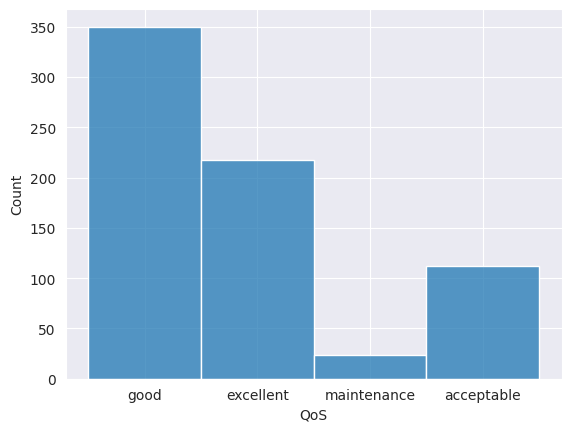

In [784]:
sns.histplot(station_df['QoS'])

In [785]:
#for exact nums
station_df['QoS'].value_counts()

QoS
good           350
excellent      217
acceptable     112
maintenance     24
Name: count, dtype: int64

In [786]:
station_df['QoS'].isna().sum()

np.int64(0)

In [787]:
#latitude (from both station_df and observation_df)
print (station_df['latitude'].min(), observation_df['latitude'].min())
print (station_df['latitude'].max(), observation_df['latitude'].max())
#the min and the max are both realistic values, from -180 to 180

set(station_df['latitude']) == set(observation_df['latitude'])
#every station is included in observation by latitude

-44.39672 -44.39672
65.84811 65.84811


True

In [788]:
#longitude (from both station_df and observation_df)
print (station_df['longitude'].min(), observation_df['longitude'].min())
print (station_df['longitude'].max(), observation_df['longitude'].max())
#the min and the max are both realistic values, from -180 to 180

set(station_df['longitude']) == set(observation_df['longitude'])
#every station is included by longitude also

#this could be checked with patient -> current location but that needs preprocessing in further steps

-156.47432 -156.47432
171.25364 171.25364


True

In [789]:
#Code (station_df)
station_df['code'].value_counts()

code
US    94
IN    51
RU    50
DE    41
BR    36
      ..
DK     1
CU     1
GH     1
AF     1
AT     1
Name: count, Length: 98, dtype: int64

<Axes: xlabel='code', ylabel='count'>

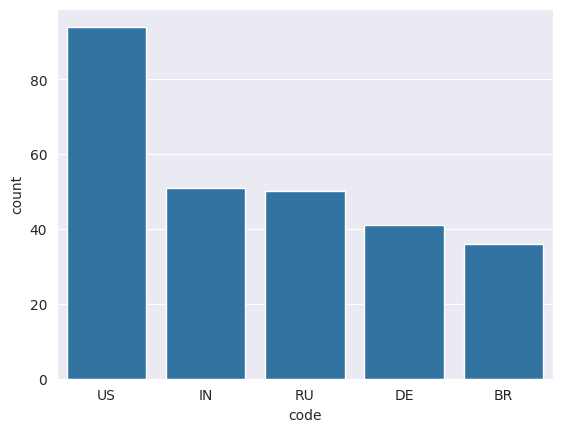

In [790]:
#top 5
top5 = station_df['code'].value_counts().head(5).reset_index()
top5.columns = ['code', 'count']

sns.barplot(x='code', y='count', data=top5)

In [791]:
#Blood group (patient_df)
patient_df['blood_group'].unique().tolist()
#All blood groups are represented

['B-', 'A-', 'O-', 'B+', 'AB-', 'A+', 'AB+', 'O+']

<Axes: xlabel='blood_group', ylabel='Count'>

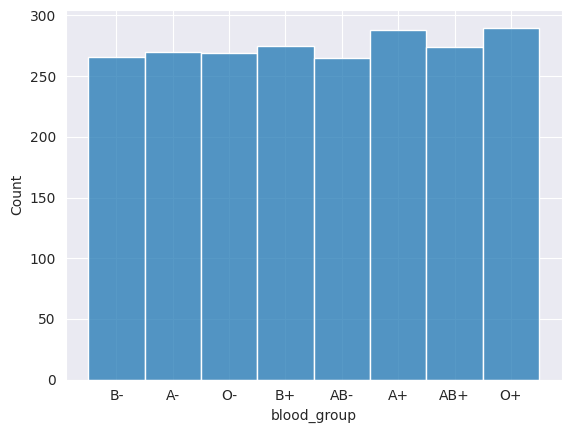

In [792]:
sns.histplot(patient_df['blood_group'])
#not that big of a range

In [793]:
patient_df['blood_group'].value_counts()

blood_group
O+     290
A+     288
B+     275
AB+    274
A-     270
O-     269
B-     266
AB-    265
Name: count, dtype: int64

In [794]:
patient_df['blood_group'].isna().sum()
#great

np.int64(0)

<Axes: ylabel='SpO₂'>

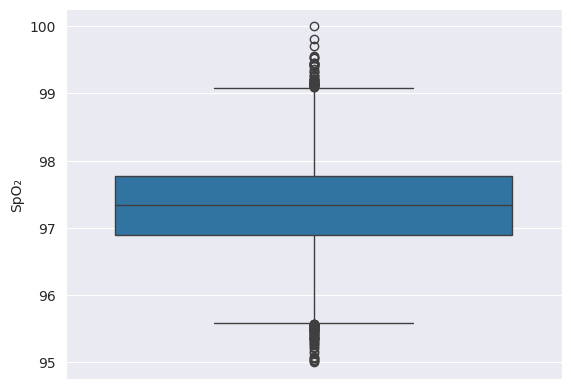

In [795]:
# SpO2
sns.boxplot(y = observation_df['SpO₂'])

In [796]:
#just to have the exact range
observation_df['SpO₂'].min(), observation_df['SpO₂'].max()
#realistic values

(np.float64(95.0), np.float64(100.0))

<Axes: xlabel='SpO₂', ylabel='Count'>

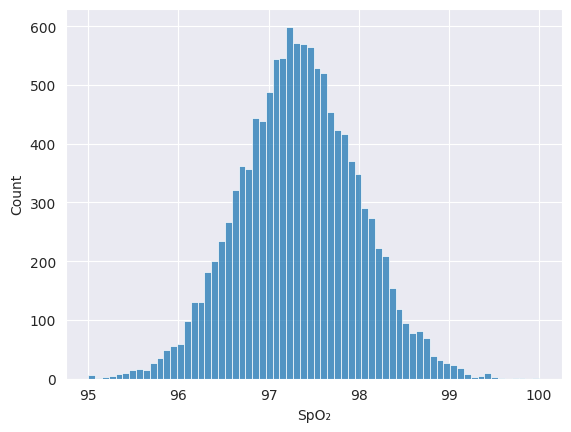

In [797]:
sns.histplot(observation_df['SpO₂'])
#normal distribution

<Axes: xlabel='Hb level', ylabel='Count'>

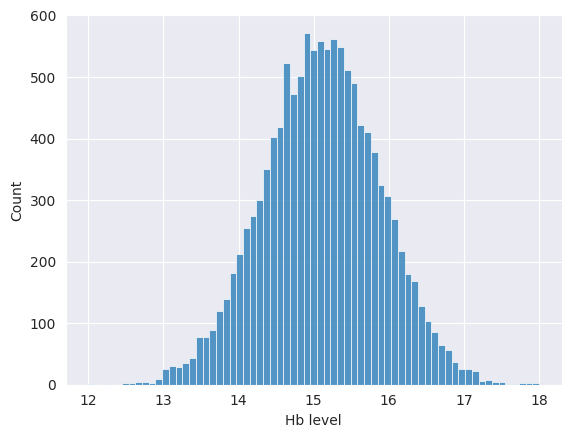

In [798]:
#Hemoglobin (Observation_df)
sns.histplot(observation_df['Hb level'])
#pretty normal, realistic values

<Axes: ylabel='Hb level'>

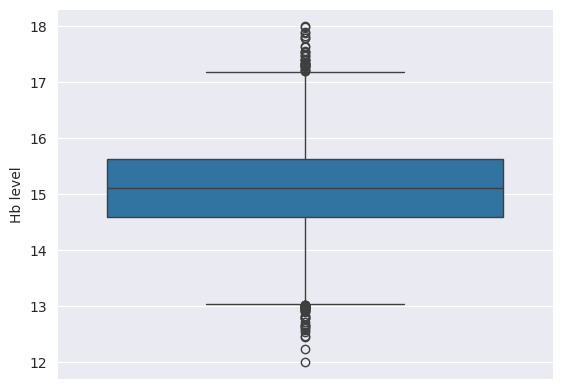

In [799]:
sns.boxplot(y = observation_df['Hb level'])

In [800]:
#exact range
observation_df['Hb level'].min(), observation_df['Hb level'].max()

(np.float64(12.0), np.float64(18.0))

<Axes: xlabel='FiO₂', ylabel='Count'>

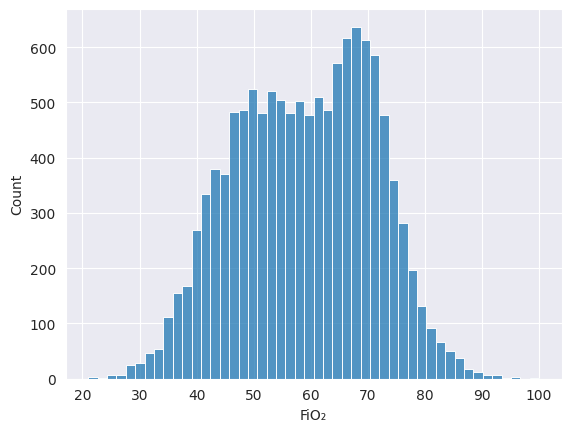

In [801]:
#Fio (Observation_df)
sns.histplot(observation_df['FiO₂'])
#not that normal, slight skew to the right at the peak
#also values are not realistic for common people, probably on oxygen therapy or something

<Axes: ylabel='FiO₂'>

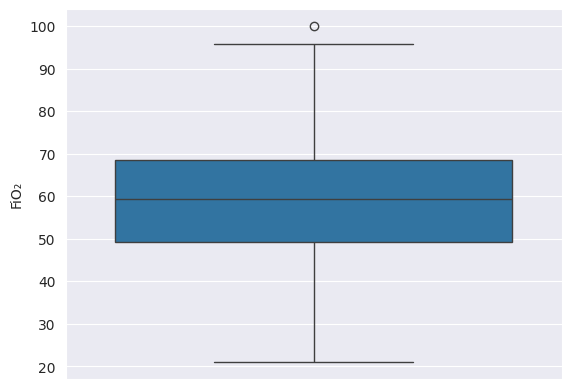

In [802]:
sns.boxplot(observation_df['FiO₂'])

<Axes: xlabel='BP', ylabel='Count'>

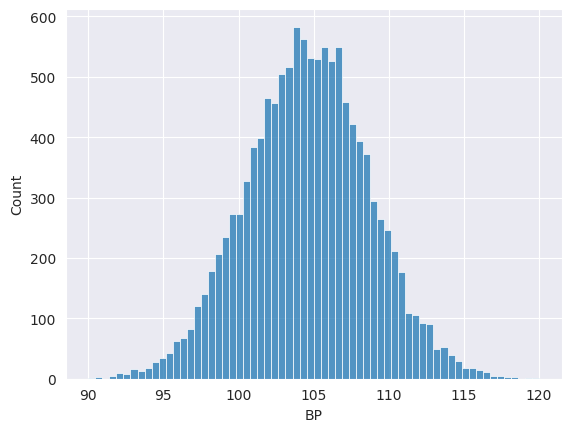

In [803]:
#blood pressure (observation_df)
sns.histplot(observation_df['BP'])
#normal distribution with usual values

<Axes: ylabel='BP'>

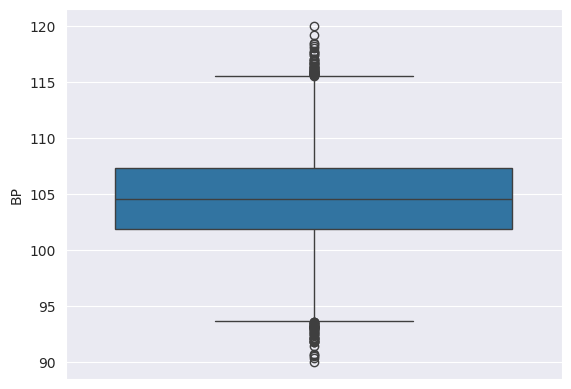

In [804]:
sns.boxplot(y = observation_df['BP'])

In [805]:
observation_df['BP'].min(), observation_df['BP'].max()

(np.float64(90.0), np.float64(120.0))

<Axes: xlabel='HR', ylabel='Count'>

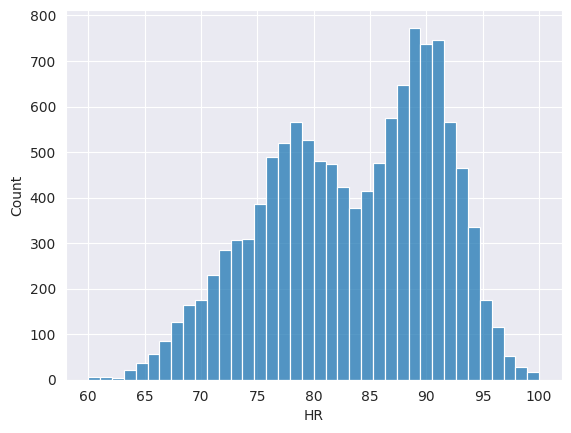

In [806]:
#Heart rate
sns.histplot(observation_df['HR'])
#pretty bimodal, but realistic values

<Axes: ylabel='HR'>

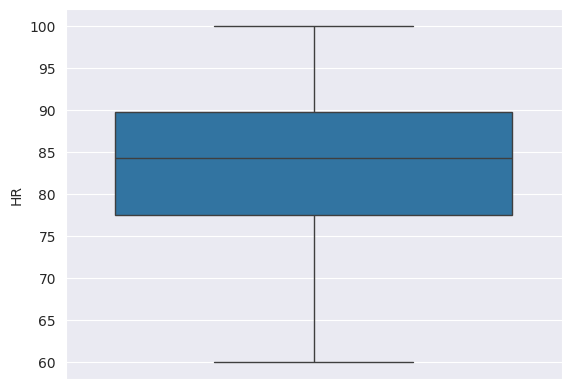

In [807]:
sns.boxplot(y = observation_df['HR'])

<Axes: xlabel='EtCO₂', ylabel='Count'>

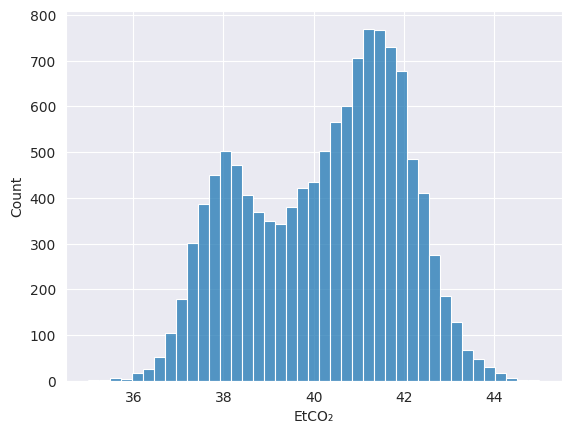

In [808]:
#ETCO2
sns.histplot(observation_df['EtCO₂'])
#also bimodal

<Axes: ylabel='EtCO₂'>

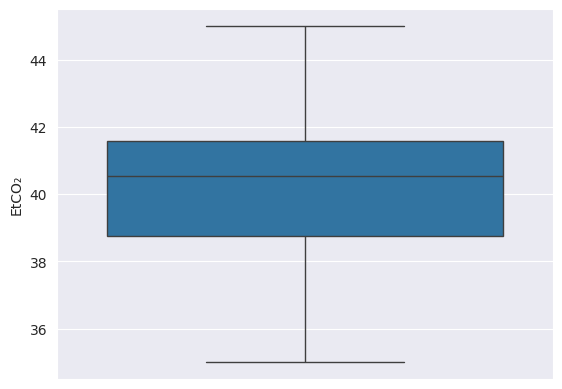

In [809]:
sns.boxplot(observation_df['EtCO₂'])

In [810]:
observation_df['EtCO₂'].min(), observation_df['EtCO₂'].max()
#also usual values

(np.float64(35.0), np.float64(45.0))

In [811]:
#just checking if this is relevant
patient_df['company'].nunique(), patient_df.shape
#too many unique vals, irrelevant

(1989, (2197, 13))

### C) Párová analýza dát: Identifikujte vzťahy a závislostí medzi dvojicami atribútov.

But first lets create a dataset with merged tables with only the attributes we consider as necessary


#### Creation of the joined df

In [812]:
#This is a list of attributes that will make up the new merged dataset

#QoS might be of significance with Fio and other atts,
#some codes may also have a touch (for example US station are healthier... idk)
#latitude and longitude will be kept for potentional current location (patient_df) relation
station_attributes = ['QoS', 'code', 'latitude', 'longitude', ]

#current location has been mentioned in station atts, may be dropped -> later comment : it was dropped
#blood group may be relevant, may be not we will see
#user id just so we have some unique user identifier since we are dropping name and everything
patient_attributes = ['user_id', 'blood_group', 'station_ID']

#everything apart from longitude and latitude since that is already kept from station_attributes and we mentioned before that all stations are mentioned in obs_df
observation_attributes = ['SpO₂', 'HR', 'PI', 'RR', 'EtCO₂', 'FiO₂', 'PRV', 'BP',
       'Skin Temperature', 'Motion/Activity index', 'PVI', 'Hb level', 'SV',
       'CO', 'Blood Flow Index', 'PPG waveform features',
       'Signal Quality Index', 'Respiratory effort', 'O₂ extraction ratio',
       'SNR', 'oximetry']

#for check, lets count the atts
len(station_attributes) + len(patient_attributes) + len(observation_attributes)

28

In [813]:
station_df2 = station_df[station_attributes].copy()
patient_df2 = patient_df[patient_attributes].copy()
observation_df2 = observation_df[observation_attributes + ['latitude', 'longitude']].copy()
#this is needed to convert the ID into a normal attribute
station_df2 = station_df2.reset_index().rename(columns={'index': 'station_ID'})

In [814]:
observation_df.shape

(12177, 23)

In [815]:
df_obs_stat = observation_df2.merge(
    station_df2,
    left_on=['latitude', 'longitude'],   # from merged patiens
    right_on=['latitude', 'longitude'],  # from observation_df
    how='inner'
)


In [816]:
#the shape should be the same as observation_df.shape
df_obs_stat.shape
#it is not because in the following cell we can see that some stations have the same coordinates

(21385, 26)

In [817]:
station_df2[['latitude', 'longitude']].duplicated().sum()

np.int64(205)

In [818]:
df_obs_stat.head(5)

,SpO₂,HR,PI,RR,EtCO₂,FiO₂,PRV,BP,Skin Temperature,Motion/Activity index,...,Signal Quality Index,Respiratory effort,O₂ extraction ratio,SNR,oximetry,latitude,longitude,station_ID,QoS,code
0,97.538229,87.194745,11.225419,14.812012,42.113735,33.852538,144.504405,100.455727,35.961920,10.302567,...,42.399816,46.497869,0.289012,39.334620,1.0,49.183239,15.454273,403,good,CZ
1,97.933271,80.787303,11.730935,14.964972,39.537692,65.326035,110.615787,102.133386,36.274352,8.975704,...,46.078137,53.351208,0.290879,26.006709,0.0,33.544280,-84.233810,4,good,US
2,97.933271,80.787303,11.730935,14.964972,39.537692,65.326035,110.615787,102.133386,36.274352,8.975704,...,46.078137,53.351208,0.290879,26.006709,0.0,33.544280,-84.233810,426,excellent,US
3,98.209983,79.733895,12.839449,14.840668,39.758706,53.925230,107.208040,104.036654,35.583851,7.653790,...,41.525607,52.124182,0.263171,31.890829,1.0,-27.505780,153.102360,219,excellent,AU
4,98.202790,86.156903,11.204152,14.523288,43.448577,35.227704,143.282224,105.723603,36.463180,8.795732,...,36.535021,50.342830,0.256780,30.721375,1.0,37.656390,126.835000,319,excellent,KR


In [819]:
#now we need to join the df_obs_stat with patient_df
df = df_obs_stat.merge(
    patient_df2,
    left_on=['station_ID'],
    right_on=['station_ID'],
    how='inner'
)

In [820]:
df.shape
#now we have many more entries since there are many patients sharing the same station as we can see in the next cell

(66973, 28)

In [821]:
patient_df2[['station_ID']].duplicated().sum()

np.int64(1520)

In [822]:
df.columns

Index(['SpO₂', 'HR', 'PI', 'RR', 'EtCO₂', 'FiO₂', 'PRV', 'BP',
       'Skin Temperature', 'Motion/Activity index', 'PVI', 'Hb level', 'SV',
       'CO', 'Blood Flow Index', 'PPG waveform features',
       'Signal Quality Index', 'Respiratory effort', 'O₂ extraction ratio',
       'SNR', 'oximetry', 'latitude', 'longitude', 'station_ID', 'QoS', 'code',
       'user_id', 'blood_group'],
      dtype='object')

#### correlation matrix with heatmap

In [823]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

corr_matrix = numeric_df.corr().round(2)

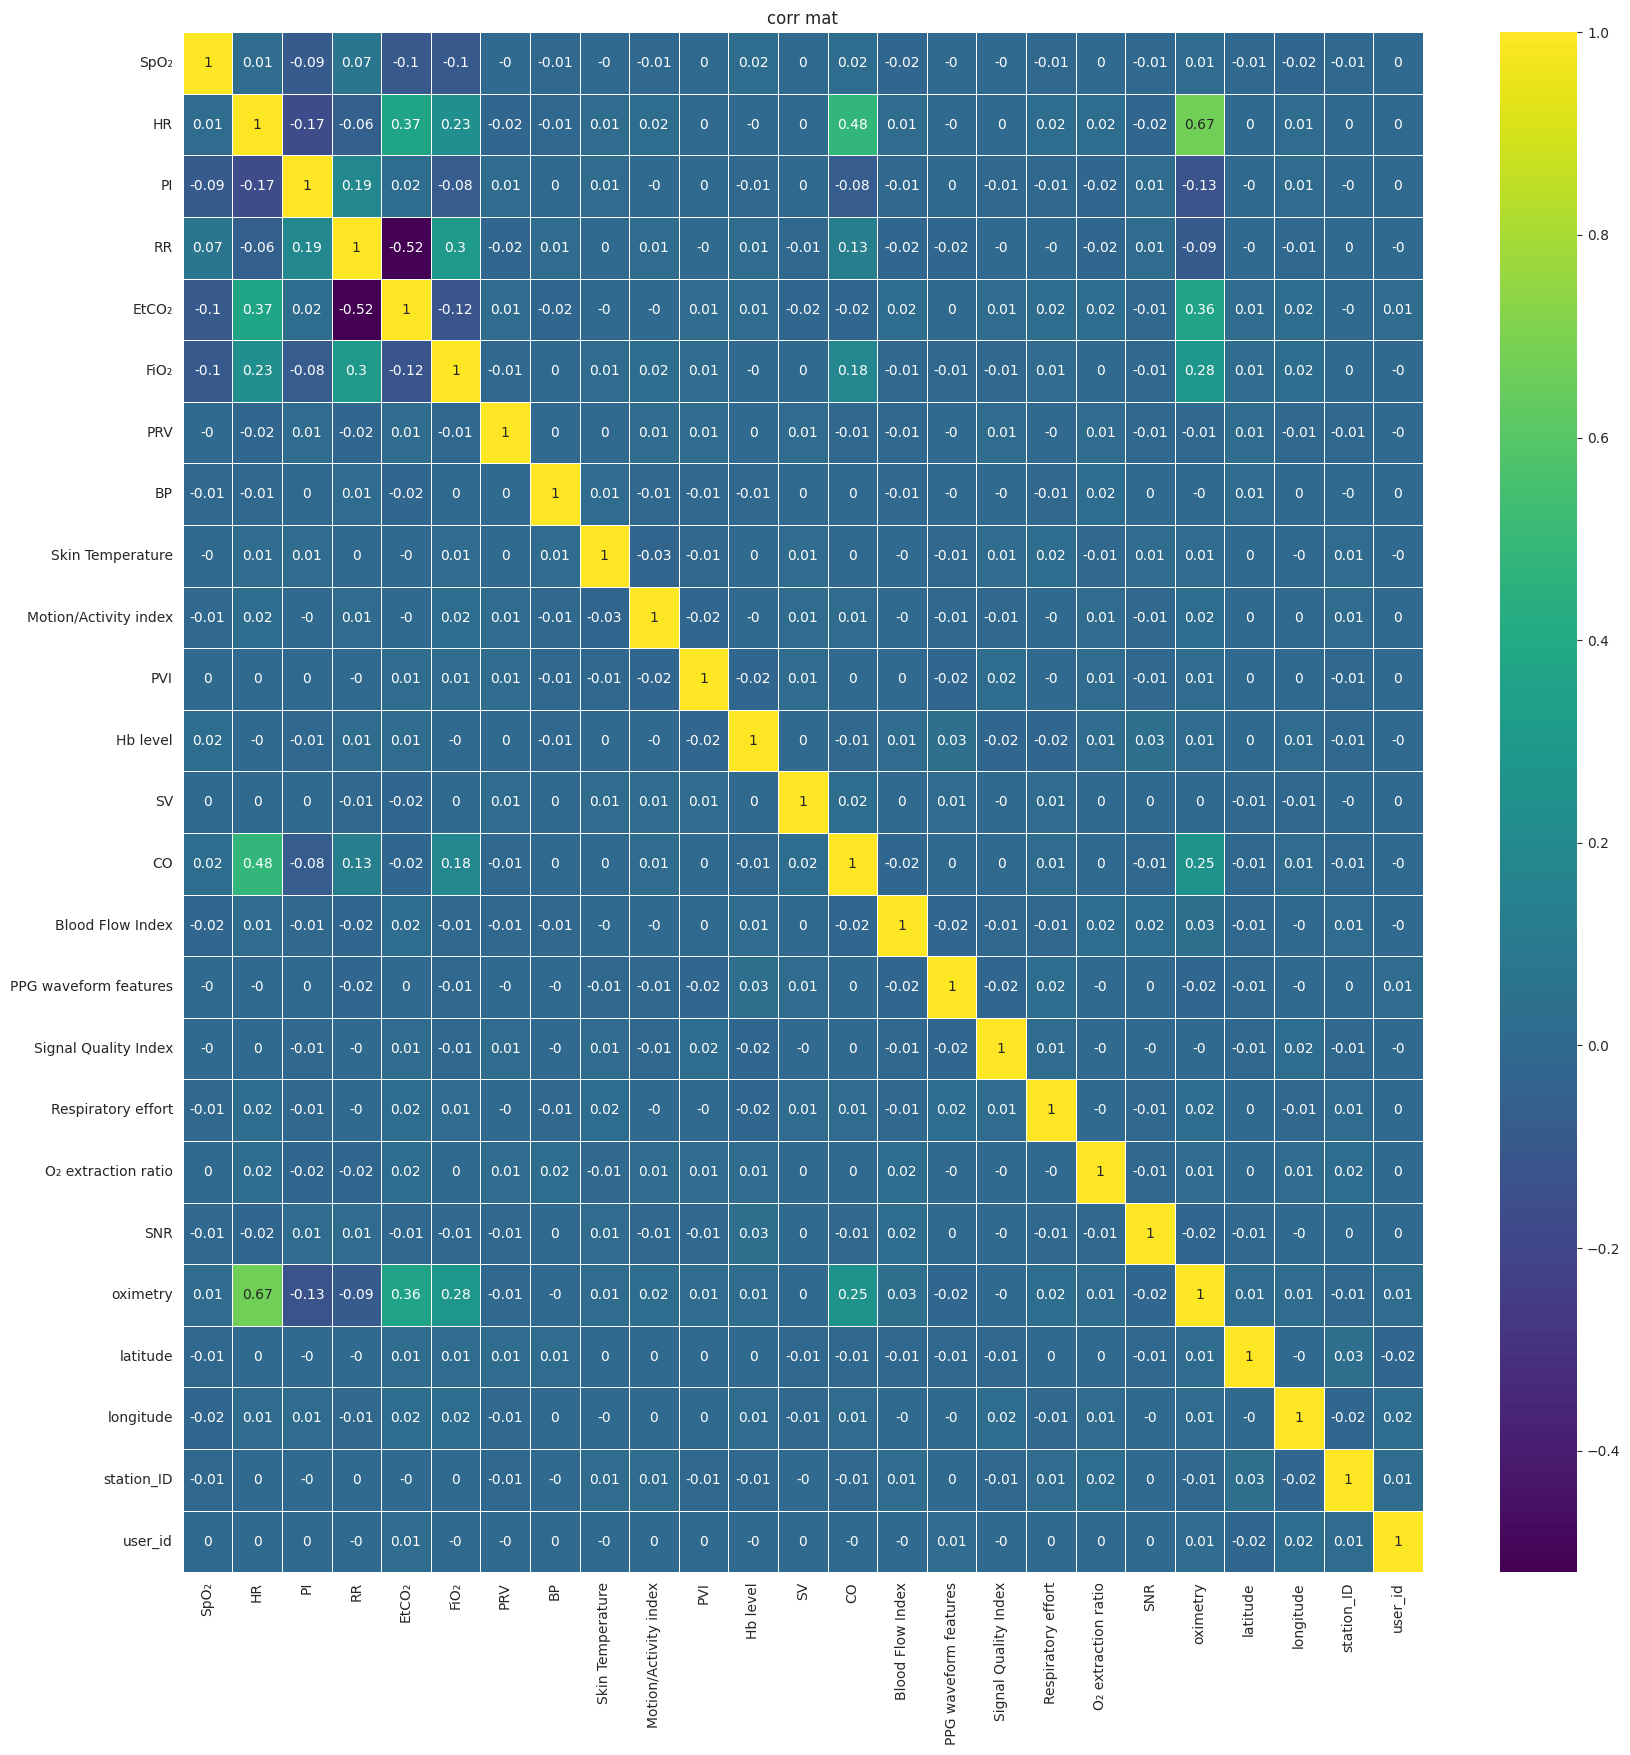

In [824]:
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='viridis', annot=True,linewidths=0.5)
plt.title("corr mat")
plt.show()

In [825]:
#based on this heatmap lets write out all the correlations so we can take a look at them later
#I only included minimum 0,2 corr

#GROUP 1 (WITHOUT OXIMETRY):            -- used in this step

#HR - EtCO2(weak), FiO2(weak), CO(mid)
#RR - Etco2(mid), FiO2(weak),

#Group 2(OXIMETRY):
#OX - HR(strong),EtCO2(weak) ,FiO2(weak), CO(weak)      -- used in 1D

#### solution for 1.1C)
here are the comparisons between the attributes we got from the correlation heatmap

<Axes: xlabel='HR', ylabel='EtCO₂'>

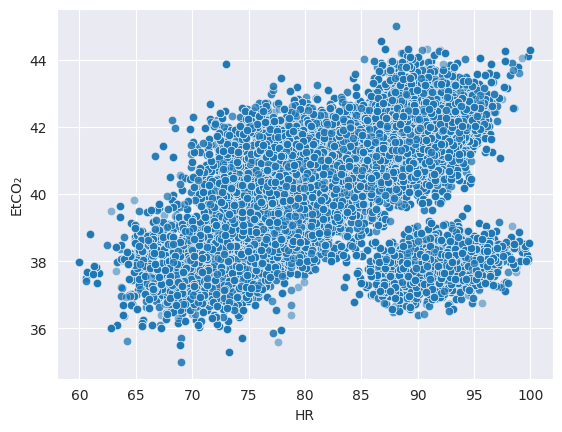

In [826]:
#HR-EtCO2
sns.scatterplot(data=df, x='HR', y='EtCO₂', alpha=0.5)

<Axes: xlabel='HR', ylabel='EtCO₂'>

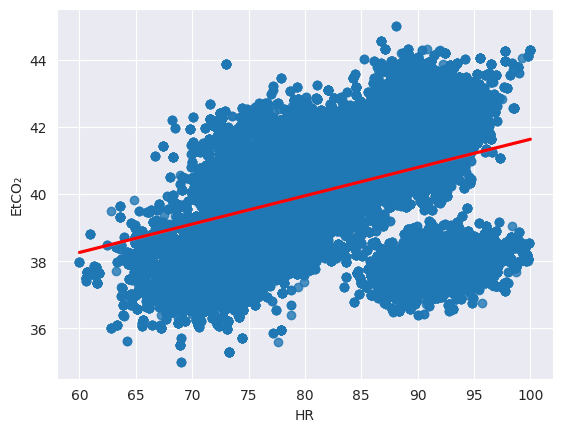

In [827]:
sns.regplot(data=df, x='HR', y='EtCO₂', line_kws={'color':'red'})

In [828]:
#this is not enough to determine that these two variables correlate, maybe without the cluster around [92.5 , 38]

<Axes: xlabel='HR', ylabel='FiO₂'>

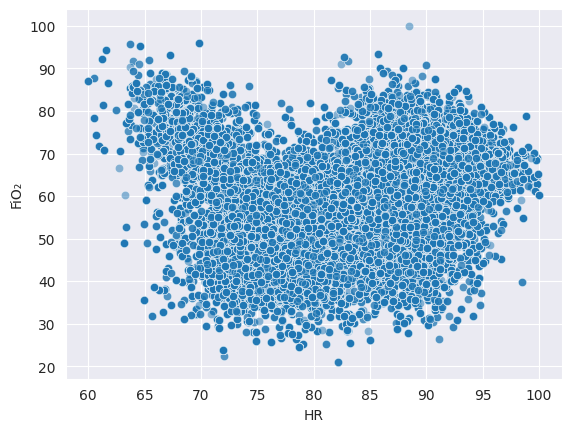

In [829]:
#HR-FiO2
sns.scatterplot(data=df, x='HR', y='FiO₂', alpha=0.5)

In [830]:
#way too spread out, insignificant

<Axes: xlabel='HR', ylabel='CO'>

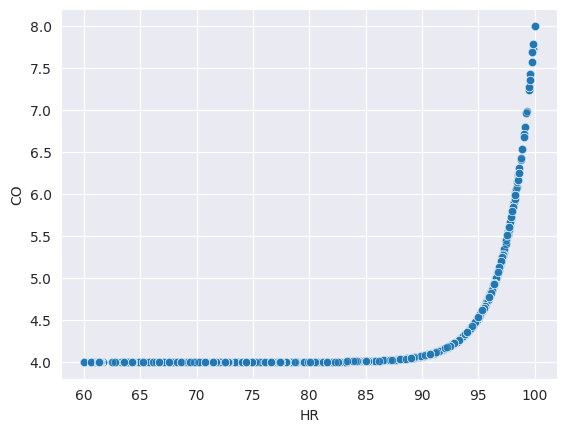

In [831]:
#HR-CO
sns.scatterplot(data=df, x='HR', y='CO', alpha=0.5)


In [832]:
#This is definitely a significant correlation, but not linear since CO values are cut off at 4.0

<Axes: xlabel='RR', ylabel='EtCO₂'>

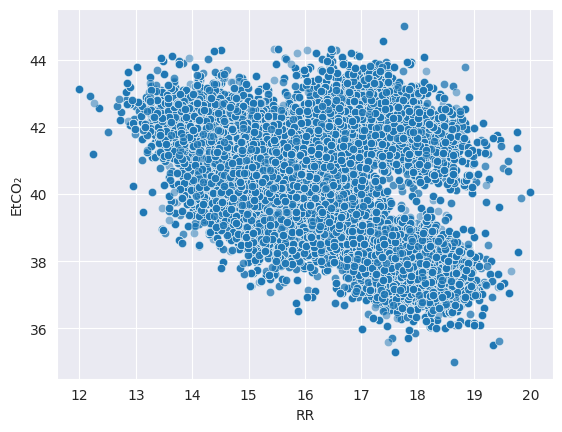

In [833]:
#RR - Etco2
sns.scatterplot(data=df, x='RR', y='EtCO₂', alpha=0.5)

In [834]:
#slight show of negative correlation, but ruined by the upper right cluster

<Axes: xlabel='RR', ylabel='FiO₂'>

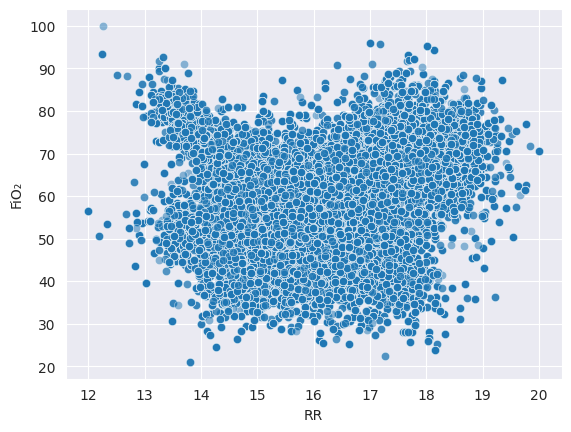

In [835]:
#RR FiO2
sns.scatterplot(data=df, x='RR', y='FiO₂', alpha=0.5)

In [836]:
#no correlation

these were only the numeric attributes we took from the heatmap, now lets take at look at non numeric correlations aswell

In [837]:
non_numeric = df.select_dtypes(exclude=['float64', 'int64']).columns
print(non_numeric)
#these will be tested for correlation with CO,FIO2 and EtCO2 since these seem to be the most important attributes

Index(['QoS', 'code', 'blood_group'], dtype='object')


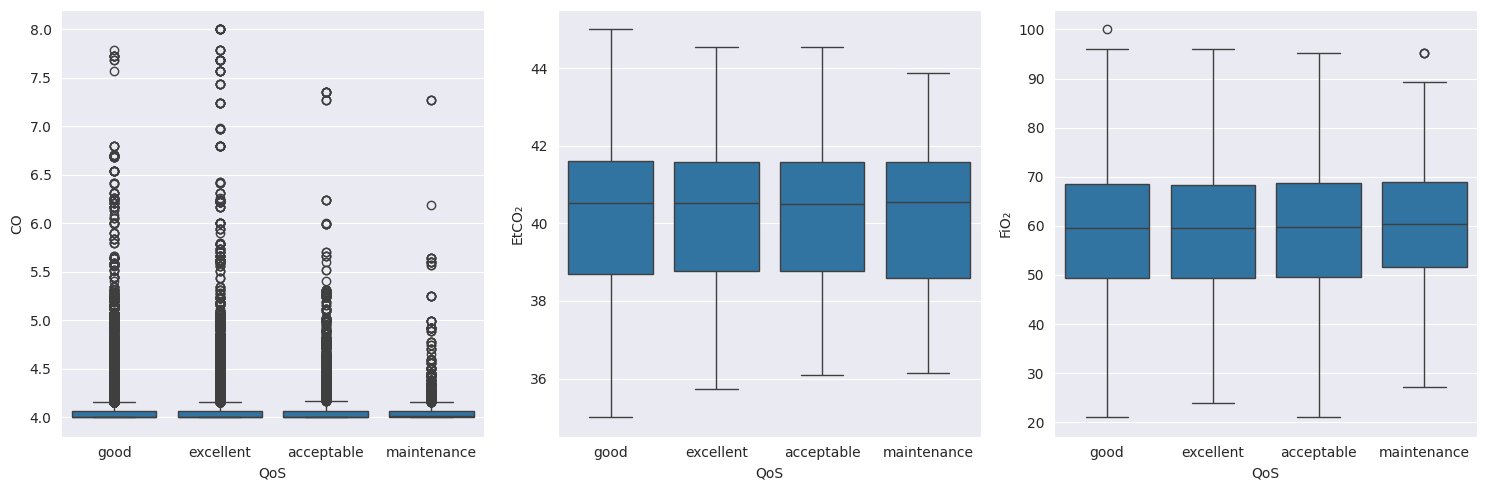

In [838]:
#QoS
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(data=df, x='QoS', y='CO', ax=axes[0])
sns.boxplot(data=df, x='QoS', y='EtCO₂', ax=axes[1])
sns.boxplot(data=df, x='QoS', y='FiO₂', ax=axes[2])

plt.tight_layout()
plt.show()
#no real significance

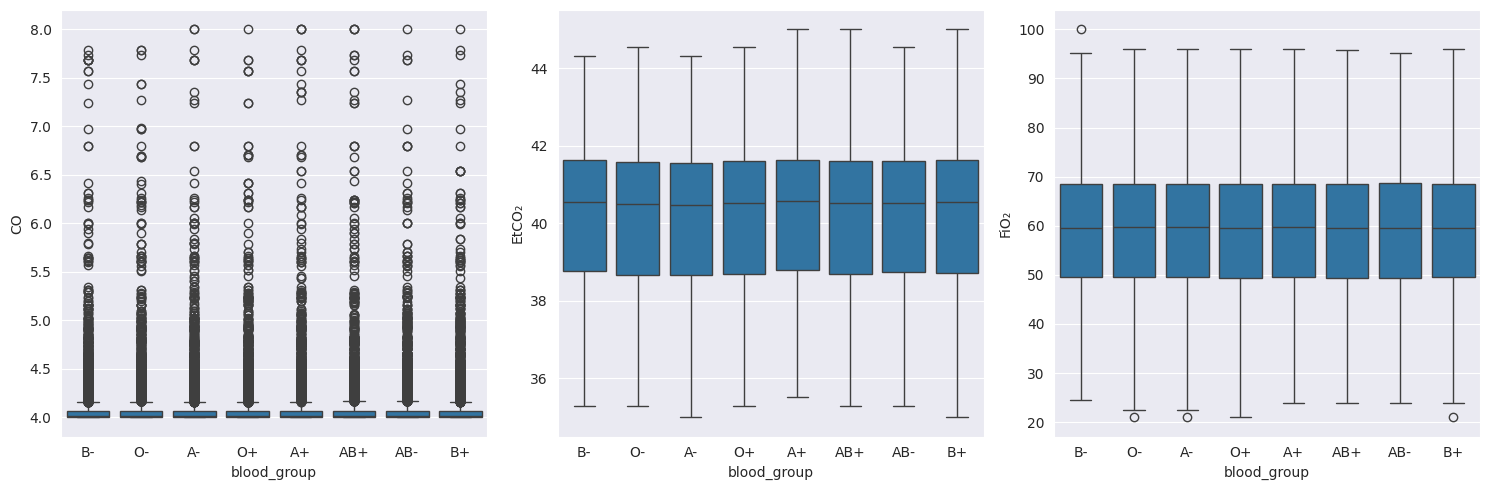

In [839]:
#QoS
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(data=df, x='blood_group', y='CO', ax=axes[0])
sns.boxplot(data=df, x='blood_group', y='EtCO₂', ax=axes[1])
sns.boxplot(data=df, x='blood_group', y='FiO₂', ax=axes[2])

plt.tight_layout()
plt.show()

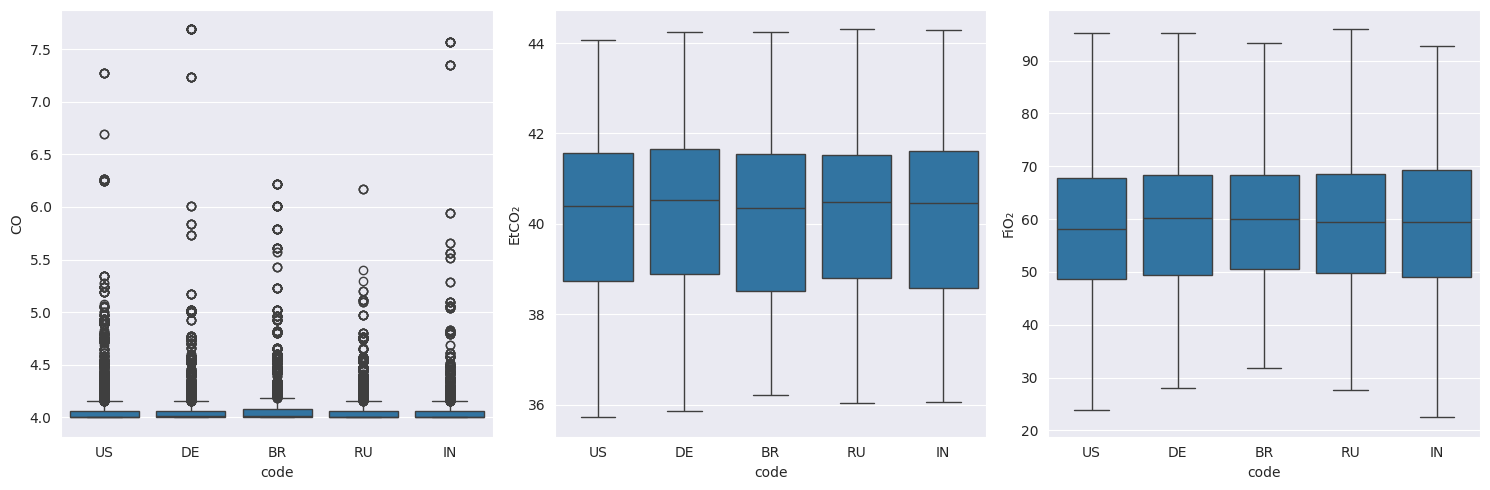

In [840]:
#code - top 5
top_codes = df['code'].value_counts().head(5).index
filtered_df = df[df['code'].isin(top_codes)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(data=filtered_df, x='code', y='CO', ax=axes[0])
sns.boxplot(data=filtered_df, x='code', y='EtCO₂', ax=axes[1])
sns.boxplot(data=filtered_df, x='code', y='FiO₂', ax=axes[2])

plt.tight_layout()
plt.show()

### D)Párová analýza dát: Identifikujte závislosti medzi predikovanou premennou a ostatnými premennými (potenciálnymi prediktormi)

from the correlation heatmap we have these attributes that seem to have some correlation with the predicted attribute

HR(strong),EtCO2(weak) ,FiO2(weak), CO(weak)

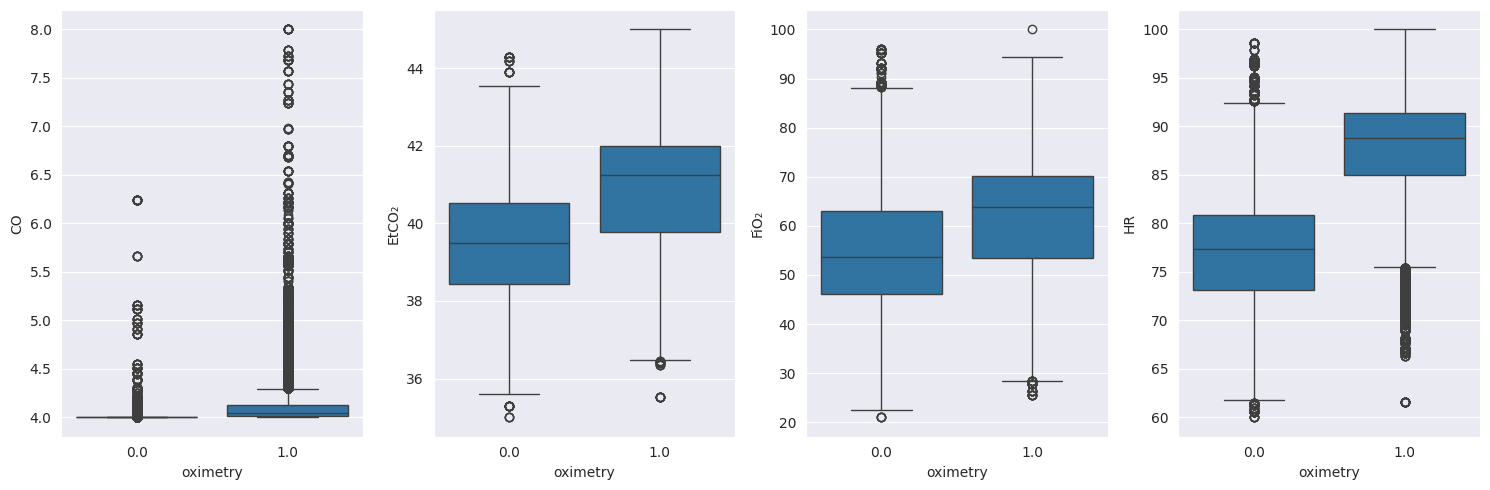

In [841]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

sns.boxplot(data=df, x='oximetry', y='CO', ax=axes[0])
sns.boxplot(data=df, x='oximetry', y='EtCO₂', ax=axes[1])
sns.boxplot(data=df, x='oximetry', y='FiO₂', ax=axes[2])
sns.boxplot(data=df, x='oximetry', y='HR', ax=axes[3])

plt.tight_layout()
plt.show()

In [842]:
#CO is hard to determine, the IQRs are close but the outliers may mean a lot (will probably see more after normalization), the EtCO2 and FiO2 seem to be higher when oximetry is set to 1, HR seems to have a really significant correlation with oximetry, as suggested by the correlation heatmap

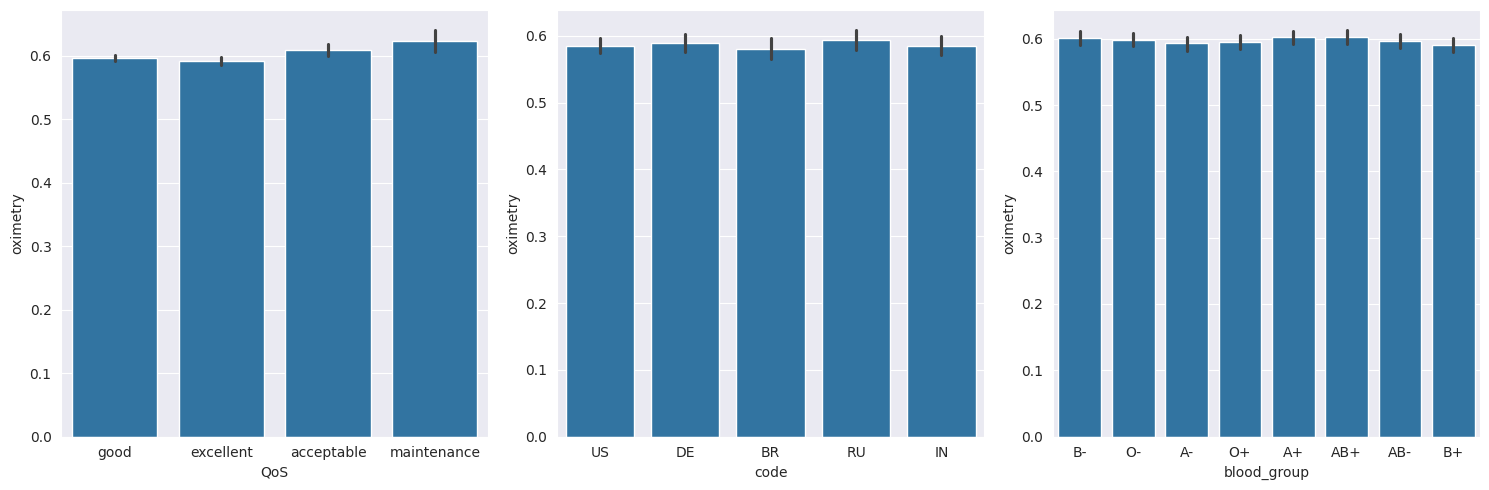

In [843]:
#correlation with non numerical values
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# QoS
sns.barplot(ax=axes[0], x=df['QoS'], y=df['oximetry'])
# code (top 5)
top5 = df['code'].value_counts().head(5).index
sns.barplot(ax=axes[1], x=df[df['code'].isin(top5)]['code'], y=df[df['code'].isin(top5)]['oximetry'])
# blood_group
sns.barplot(ax=axes[2], x=df['blood_group'], y=df['oximetry'])

plt.tight_layout()
plt.show()


In [844]:
#this graphs show the oximetry 1/0 ratio per each QoS, Code and blood group. So rather than correlation, this shows that the data are evenly distributed

### E) Findings, thought ect.

all of our thoughs and findings are thoroughly documented throughout the operations, but here is the summary:

Firstly we analysed each table and gave a quick look for every attribute, for dataset station, we used the coordinations to merge it with observation_df, we ended up not using the station name as it is insignificant as well as revision. The only missing values were 2 codes which will probably be filled later with a newly created code. The patient dataframe is full of insignificant attributes, we end up only using the blood group and station ID for merge with station df. From observation we keep every value, although some seem to be more signicicant than others, for example FiO2, CO,RR, EtCO2. We take some time to look at individual distributions of attributes in B), but we dont really find any abnormalities that would pose a threat to our models precition, most distributions are either normal or bimodal or uniform. In C) we needed to take a look at correlation between the attributes, so we needed to create a correlation heatmap which was created from a joint dataframe consisting of all three datasets, but only the attributes that we deemed as important. We discarded the useless features and we will not work with them from that point onward. However we find out minor correlation between HR and EtCO2 as well as a negative one between HR and FiO2 and a RR and EtCO2. HR and CO seem to have a strong positive correlation but since CO is capped at 4.0, it is not shown that nicely. In D) we see that the predicted value oximetry strongly correlates with HR, and FiO2 and EtCO2 also show medium signs of correlation. Correlation with CO is harder to determine without normalising the data first.

## 1.2 Identifikácia problémov, integrácia a čistenie dát

### A) nevhodná štruktúra, nejednotne formaty ,duplikáty, chýbajúce hodnoty, vychýlene hodnoty, abnormalne hodnoty, nelogické vzťahy


In [845]:
df.columns

Index(['SpO₂', 'HR', 'PI', 'RR', 'EtCO₂', 'FiO₂', 'PRV', 'BP',
       'Skin Temperature', 'Motion/Activity index', 'PVI', 'Hb level', 'SV',
       'CO', 'Blood Flow Index', 'PPG waveform features',
       'Signal Quality Index', 'Respiratory effort', 'O₂ extraction ratio',
       'SNR', 'oximetry', 'latitude', 'longitude', 'station_ID', 'QoS', 'code',
       'user_id', 'blood_group'],
      dtype='object')

In [846]:
# I see many collumn name that are corectly name but it is so anoying to copy the same `₂` symbol over and over again so that's why im gonna rename it just for now

rename_map = {
    'SpO₂': 'SpO2',
    'EtCO₂': 'EtCO2',
    'FiO₂': 'FiO2',
    'O₂ extraction ratio': 'O2 extraction ratio',
}
df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})

In [847]:
for c in ['QoS','code','blood_group']:
    if c in df.columns:
        df[c] = df[c].astype('category')


In [848]:
#checking if every value in oximetry col is type int so it does not make any issues in the future but most of this is already done in previous cells in 1.1

if 'oximetry' in df.columns:
    df['oximetry'] = df['oximetry'].astype(int)

In [849]:
df.dtypes.value_counts()


float64     22
int64        3
category     1
category     1
category     1
Name: count, dtype: int64

In [850]:
df.duplicated().sum()

np.int64(0)

In [851]:
df.duplicated(subset=['HR','RR','BP']).sum()

np.int64(55244)

In [852]:
duplicates_output = df[df.duplicated(subset=[col for col in df.columns if col != 'user_id'], keep=False)]
duplicates_output

,SpO2,HR,PI,RR,EtCO2,FiO2,PRV,BP,Skin Temperature,Motion/Activity index,...,O2 extraction ratio,SNR,oximetry,latitude,longitude,station_ID,QoS,code,user_id,blood_group
6,97.933271,80.787303,11.730935,14.964972,39.537692,65.326035,110.615787,102.133386,36.274352,8.975704,...,0.290879,26.006709,0,33.54428,-84.23381,426,excellent,US,398,O+
7,97.933271,80.787303,11.730935,14.964972,39.537692,65.326035,110.615787,102.133386,36.274352,8.975704,...,0.290879,26.006709,0,33.54428,-84.23381,426,excellent,US,988,O+
9,97.933271,80.787303,11.730935,14.964972,39.537692,65.326035,110.615787,102.133386,36.274352,8.975704,...,0.290879,26.006709,0,33.54428,-84.23381,426,excellent,US,2033,O+
30,96.851933,91.008225,11.323571,15.148349,42.056062,58.615353,77.660061,102.695264,35.163246,11.823341,...,0.285955,32.768112,1,10.29085,105.75635,663,excellent,VN,1225,A-
32,96.851933,91.008225,11.323571,15.148349,42.056062,58.615353,77.660061,102.695264,35.163246,11.823341,...,0.285955,32.768112,1,10.29085,105.75635,663,excellent,VN,1454,A-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66965,96.698981,71.499309,13.427977,15.751513,41.201634,55.177636,103.386006,102.693239,34.895596,11.429244,...,0.283565,28.887543,1,51.04962,12.13690,223,excellent,DE,575,B-
66966,96.698981,71.499309,13.427977,15.751513,41.201634,55.177636,103.386006,102.693239,34.895596,11.429244,...,0.283565,28.887543,1,51.04962,12.13690,223,excellent,DE,468,O+
66967,96.698981,71.499309,13.427977,15.751513,41.201634,55.177636,103.386006,102.693239,34.895596,11.429244,...,0.283565,28.887543,1,51.04962,12.13690,223,excellent,DE,1212,B-
66968,96.698981,71.499309,13.427977,15.751513,41.201634,55.177636,103.386006,102.693239,34.895596,11.429244,...,0.283565,28.887543,1,51.04962,12.13690,223,excellent,DE,928,B-


In [853]:
duplicates_output['user_id'].nunique(), len(duplicates_output)

(599, 21334)

In [854]:
duplicates_output['station_ID'].value_counts().head()

station_ID
186    468
8      414
350    352
208    318
223    318
Name: count, dtype: int64

After checking for duplicates, we found that some patients shared identical measurements. It is normal but not if we found out that 21 336 row that are similar.
This was caused by merging patient_df and observation_df using station_ID.



In [855]:
na_count = df.isna().sum().sort_values(ascending=False)
na_count

code                     170
SpO2                       0
PI                         0
HR                         0
EtCO2                      0
FiO2                       0
PRV                        0
BP                         0
Skin Temperature           0
Motion/Activity index      0
PVI                        0
RR                         0
Hb level                   0
SV                         0
Blood Flow Index           0
CO                         0
Signal Quality Index       0
Respiratory effort         0
O2 extraction ratio        0
PPG waveform features      0
SNR                        0
oximetry                   0
longitude                  0
latitude                   0
station_ID                 0
QoS                        0
user_id                    0
blood_group                0
dtype: int64

### B) Kontrola správnosť v dátach


Most of the analyzing the atributes was done in part 1.1, individual findings were docummented along the way.

 Some of the most important findings that were captured along the way about the abnormality of the data could be divided into 3 groups. 1) Value-range-wise, most of the attributes have real values, for example the latitude and longitude do range from -180 to 180, SPO2 and blood groups are also in check and so are many more atributes. The only attribute where this was not the case would be FIO2, where the patients must have been altered from normal people, for example on oxygen therapy. 2) Distribution-wise, no attributes are abnormaly different. Some distributions were normal, e.g. SPO2, Hb level. Some were uniform, for example blood group. Some were bimodal, for example HR or EtCO2 which does show quite a skew to abnormality. FIO2 is slightly abnormal, but in most values it would pass as a normal distribution. 3) Shape-wise, patients current location is mapped as an object, but we did not waste time with asserting this issue as we dropped the column alltogether. The station's revision attribute is also an anomaly, since the shape is inconsistent, sometimes having only the date, sometimes also the time... The residence attribute is empty, having no entries

Illogical relationships would also be the division of the data into three tables. What struck me the most was the inability to find a patients observation, due to the fact that after merging patients and stations, we find out that multiple patient are linked to a singular station, and no further link to observation is provided apart than a 1:many relationship between a station and an observation with coordinates.

### C) Outlier detection

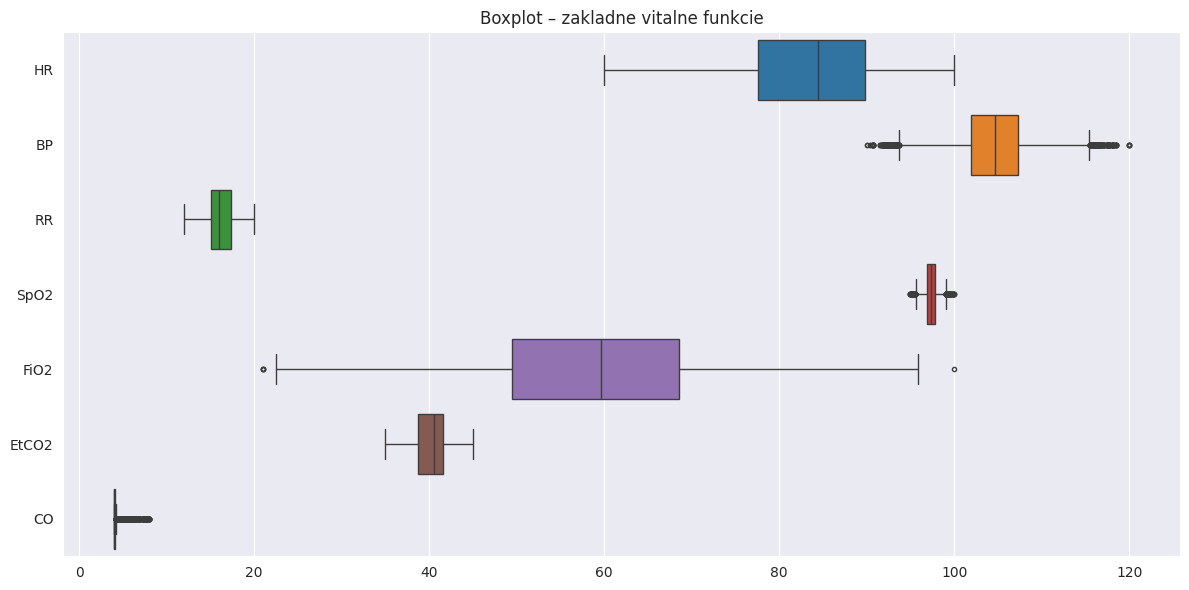

In [856]:
cols1 = ['HR', 'BP', 'RR', 'SpO2', 'FiO2', 'EtCO2',"CO"]
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[cols1], orient='h', fliersize=3)
plt.title('Boxplot – zakladne vitalne funkcie')
plt.tight_layout()
plt.show()


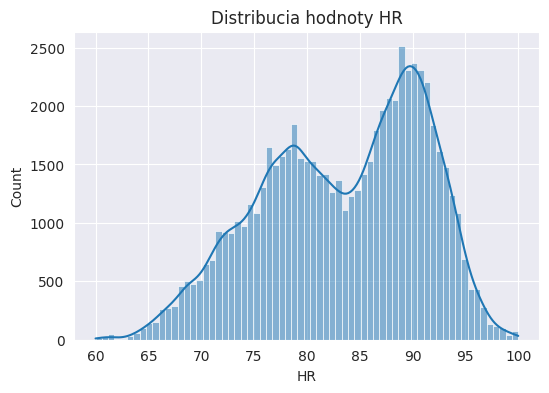

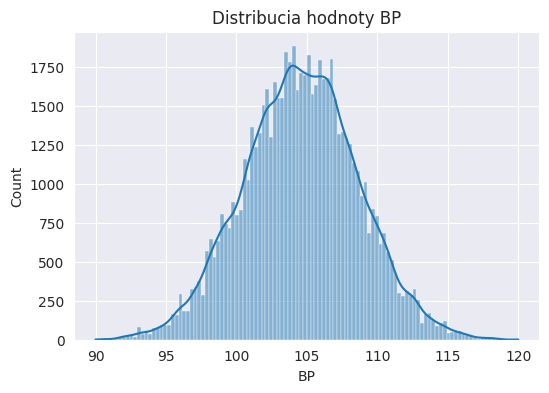

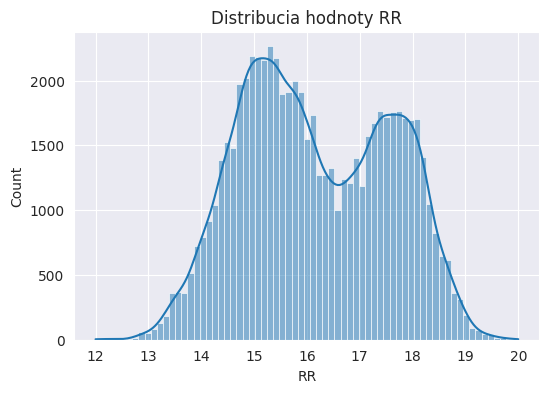

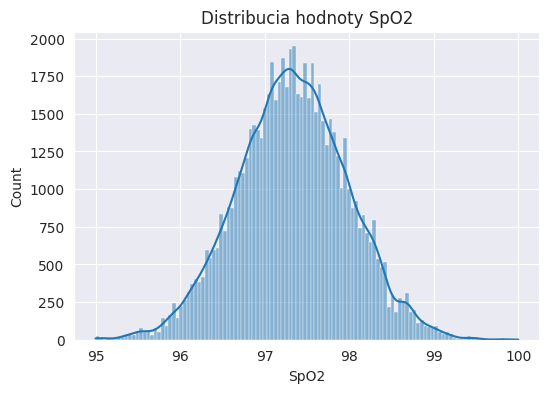

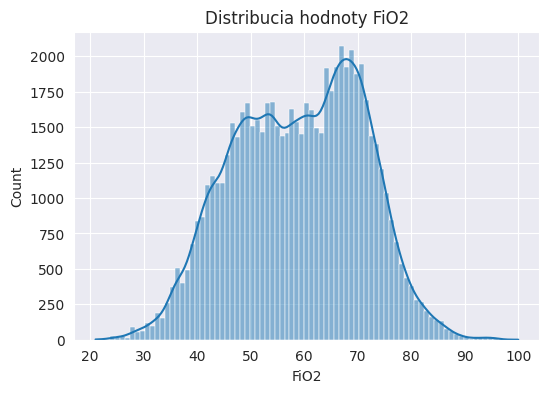

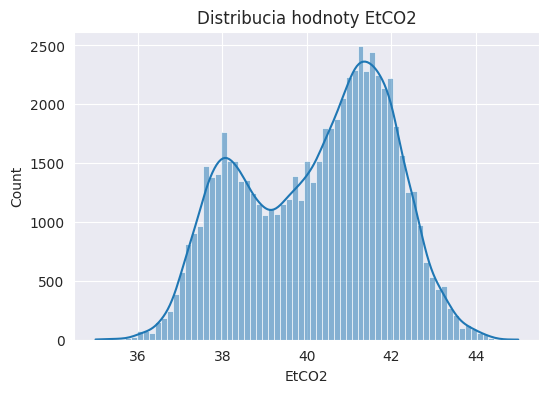

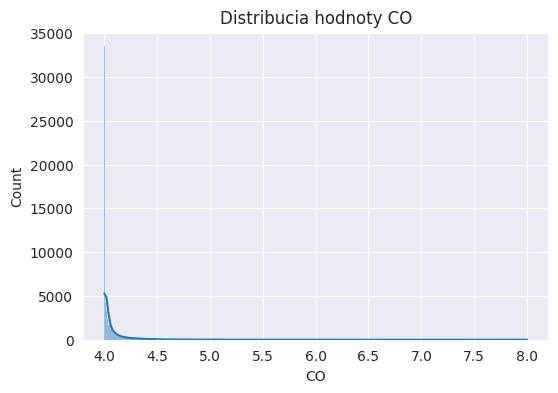

In [857]:
for col in cols1:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribucia hodnoty {col}')
    plt.show()


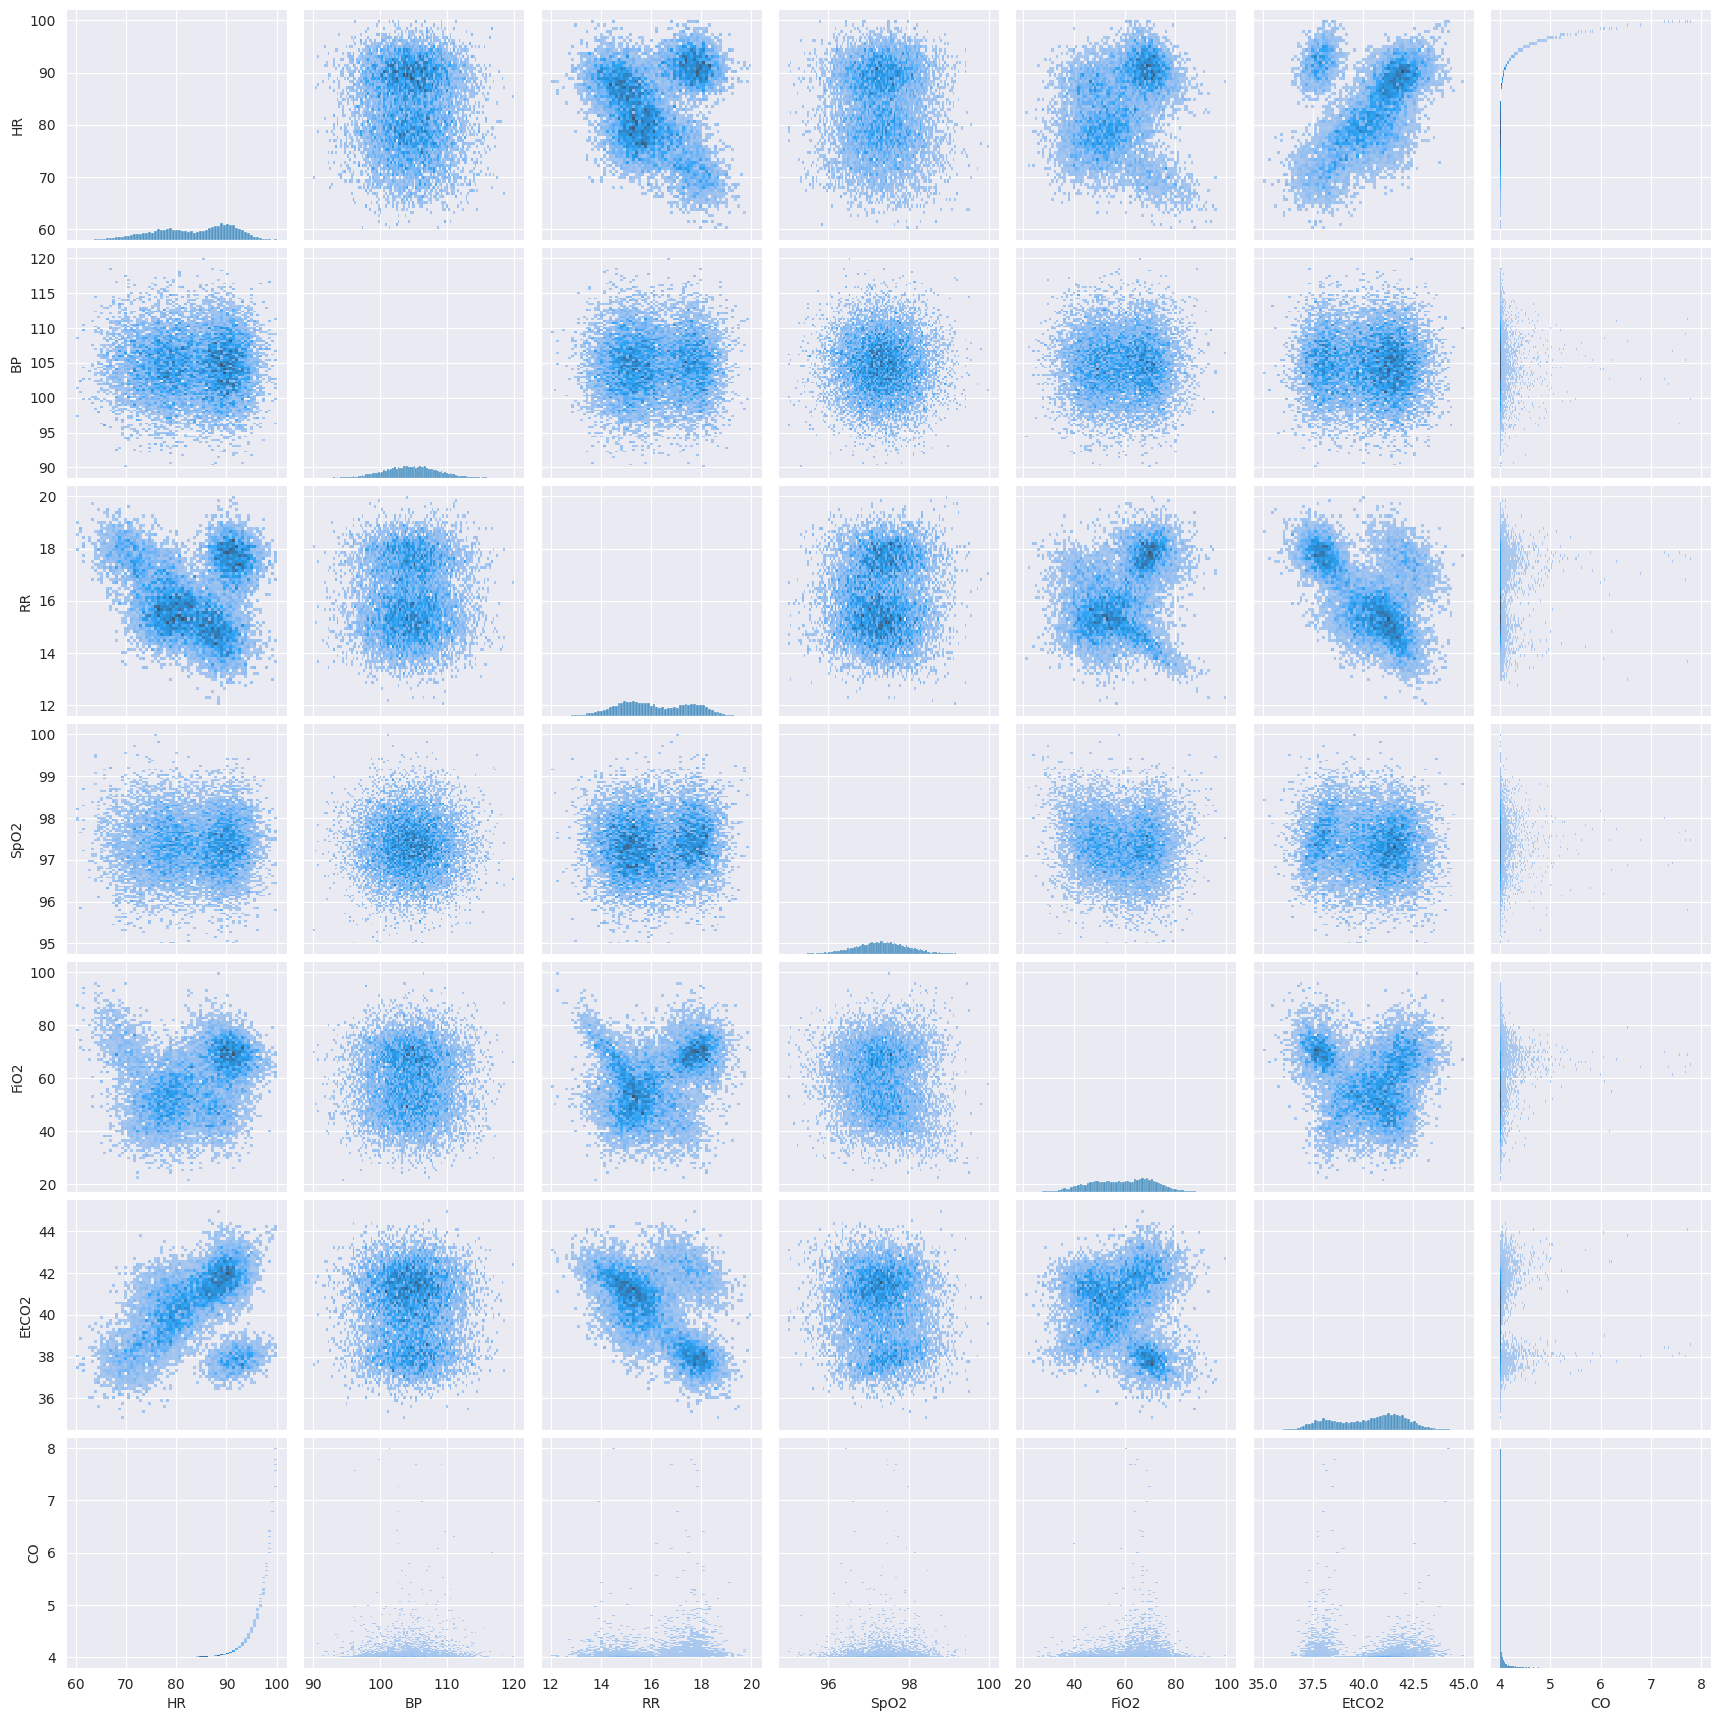

In [858]:
sns.pairplot(data=df[cols1], kind='hist')

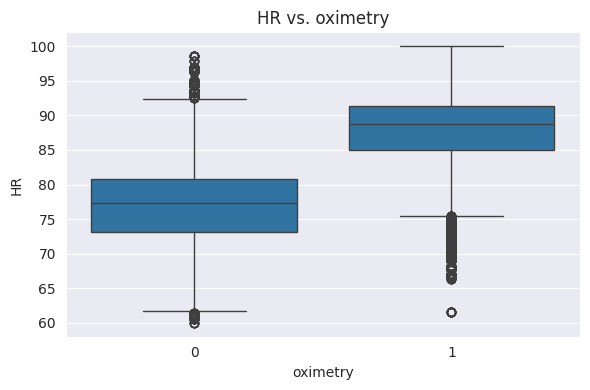

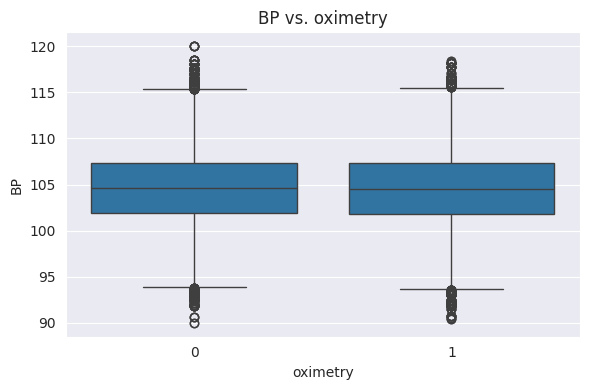

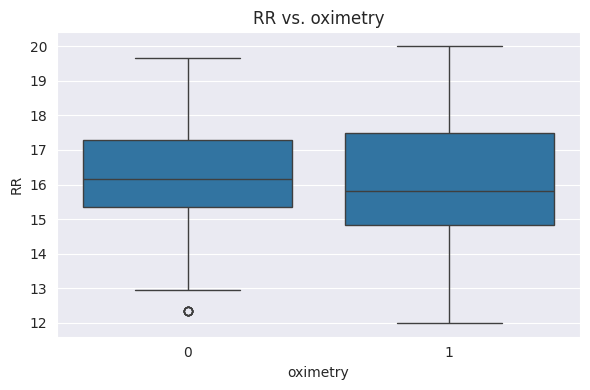

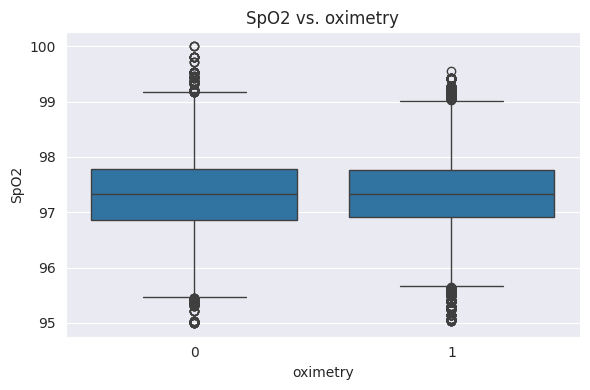

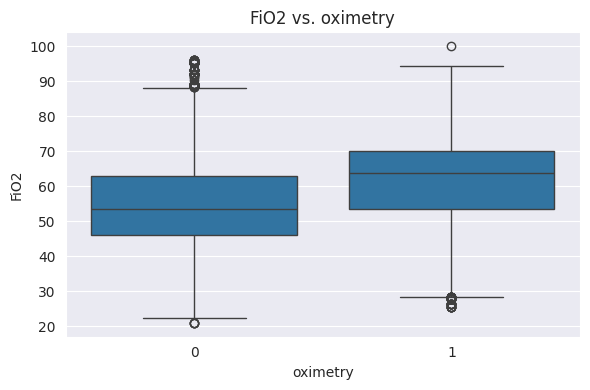

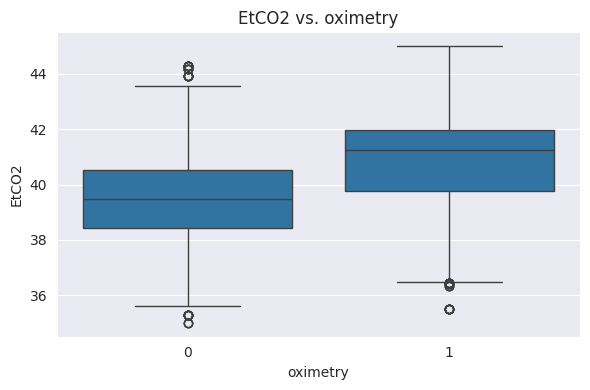

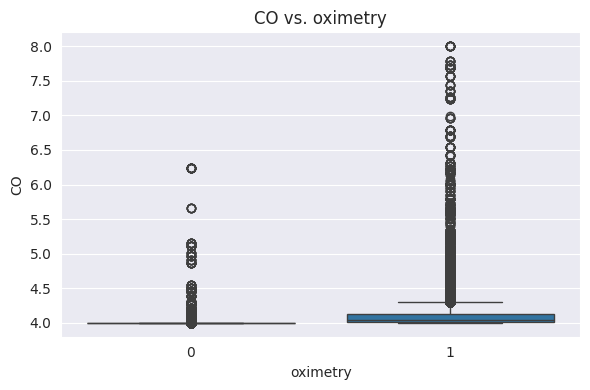

In [859]:
for col in cols1:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x='oximetry', y=col)
    plt.title(f'{col} vs. oximetry')
    plt.tight_layout()
    plt.show()


In [860]:
# HR (Heart Rate) showed several extreme values .Very high for oximetry = 0 and very low for oximetry = 1.
#These outliers can affect model accuracy, so in the next phase we will clean them using the IQR method and winsorization (5th–95th percentile) to keep only realistic heart rate values.

#The CO variable shows a highly right-skewed distribution with a long upper tail, indicating a large number of potential outliers compared to other attributes.
#These extreme values are likely to distort the model, so CO will require normalization or outlier treatment (IQR filtering or winsorization).

Before winsorization: 6696 outliers
After winsorization: 0 outliers


<Axes: xlabel='oximetry', ylabel='HR'>

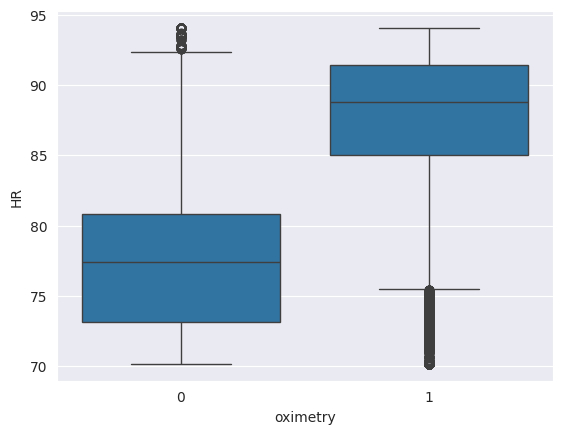

In [861]:
# Calculate 5th and 95th percentiles
low, high = df['HR'].quantile([0.05, 0.95])

# before winsorization
before = ((df['HR'] < low) | (df['HR'] > high)).sum()

# apply wins.
df_win = df.copy()
df_win['HR'] = df_win['HR'].clip(lower=low, upper=high)

# after winsorization
after = ((df_win['HR'] < low) | (df_win['HR'] > high)).sum()

print(f"Before winsorization: {before} outliers")
print(f"After winsorization: {after} outliers")

sns.boxplot(data = df_win, x='oximetry', y='HR')

Now I can see that there is not such a values that are higher or lower to quntile range from 0.05 to 0.95 that's why we did not get any after winsortization value on the other hand we caught some outliers with the IQR method on df["CO"] atribute because he included many abnormal values


In [862]:
# IQR bounders
Q1 = df['CO'].quantile(0.25)
Q3 = df['CO'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"CO bounds (IQR): {lower_bound:.2f} - {upper_bound:.2f}")

# delete values out of range
df_iqr = df[(df['CO'] >= lower_bound) & (df['CO'] <= upper_bound)]

print(f"Removed {len(df) - len(df_iqr)} rows")
print(len(df_iqr))

CO bounds (IQR): 3.91 - 4.16
Removed 8460 rows
58513


<Axes: xlabel='oximetry', ylabel='CO'>

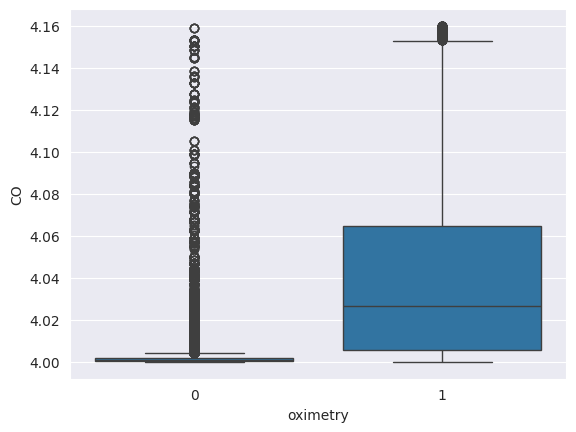

In [863]:
sns.boxplot(data=df_iqr, x='oximetry', y='CO')


On the graph above we can see extreme difference on outlier values because the previous graph had values close to 9 and this has maximum values 4.16

In [864]:
# all number collumns exept oximetry
num_cols = df.select_dtypes(include='number').columns.drop('oximetry', errors='ignore')

#add collumns if in range of upper or lower bounder
iqr_summary = []
for col in num_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    iqr_summary.append([col, outliers, round(outliers / len(df) * 100, 2)])

# Display as a small DataFrame
iqr_df = pd.DataFrame(iqr_summary, columns=['Column', 'Outliers', 'Percent'])
iqr_df.sort_values('Percent', ascending=False, inplace=True)
iqr_df

,Column,Outliers,Percent
13,CO,8460,12.63
2,PI,785,1.17
6,PRV,633,0.95
20,latitude,627,0.94
14,Blood Flow Index,602,0.90
0,SpO2,587,0.88
7,BP,560,0.84
15,PPG waveform features,549,0.82
21,longitude,544,0.81
17,Respiratory effort,468,0.70


It's bad practice to analyze a atribute one by one so I created a list of numeric values that I can analyze at once. I calculated they're IQR based on dividing they're quantile (0.25 and 0.75) .If any value is less than lower value (<0.25) that it is added to list of outliers this process also include calculating if value is greater that upper bounder (>0.75).

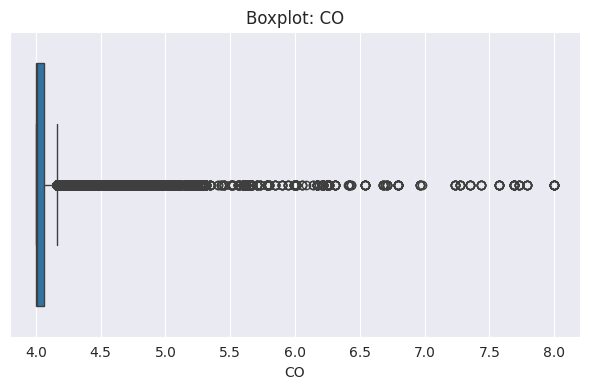

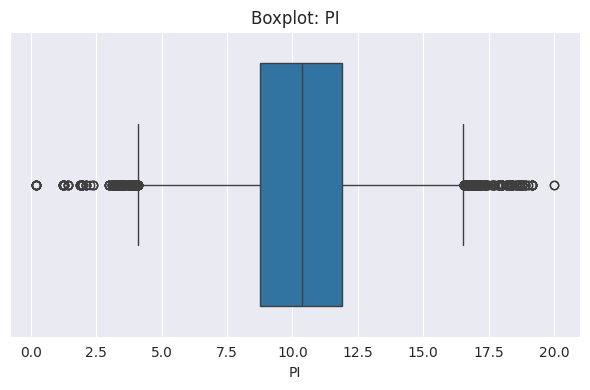

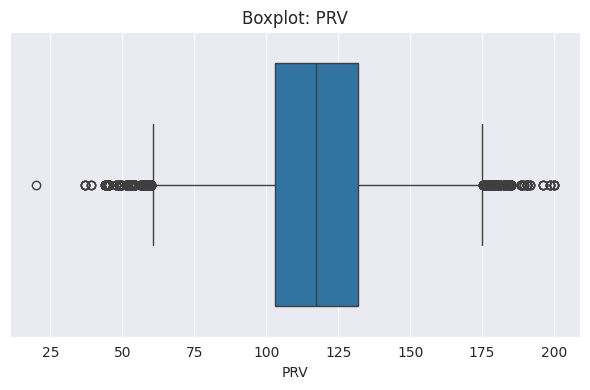

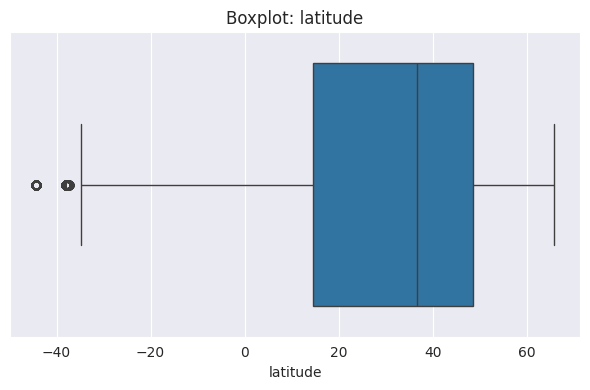

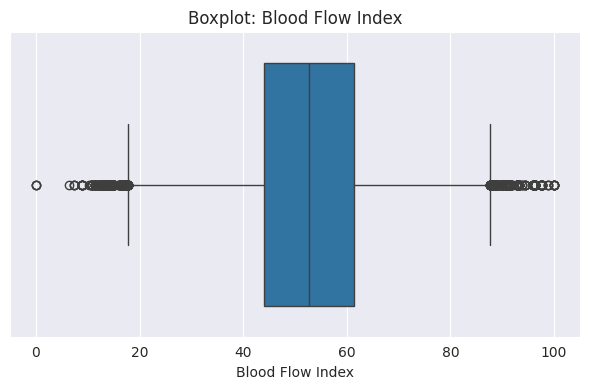

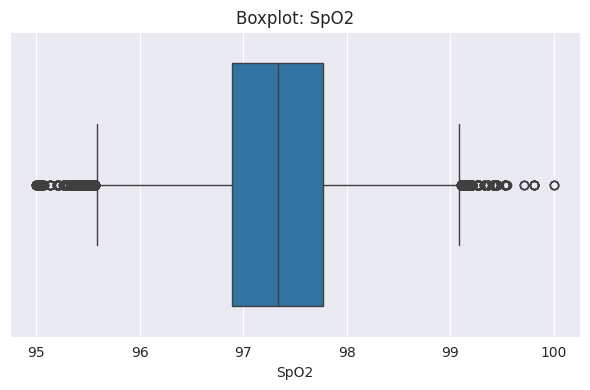

In [865]:
suspects = iqr_df[ iqr_df['Outliers'] > 0 ]['Column'].head(6).tolist()

for col in suspects:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot: {col}')
    plt.tight_layout()
    plt.show()

## 1.3 Formulácia a štatistické overenie hypotéz o dátach

### Zle hypotezy

#### Hypotéza 1 – rozdiel v tepovej frekvencii podľa stavu saturácie

##### H₀ (Null Hypothesis):
The mean heart rate (HR) is the same for both groups — patients with oximetry = 0 and oximetry = 1.

##### H₁ (Alternative Hypothesis):
The mean heart rate (HR) differs between the groups — patients with oximetry = 0 and oximetry = 1.

In [866]:
const_shapiro = 5000
# I will create 2 datasets hro0 (HE and oximtery = 0) and hro1 (HE column and oximetry = 1)
hr0 = df[df['oximetry'] == 0]['HR']
hr1 = df[df['oximetry'] == 1]['HR']


sample_hr0 = hr0.sample(const_shapiro, random_state=42)
sample_hr1 = hr1.sample(const_shapiro, random_state=42)

print(shapiro(sample_hr0))
print(shapiro(sample_hr1))

ShapiroResult(statistic=np.float64(0.9964622127654921), pvalue=np.float64(1.50860565376863e-09))
ShapiroResult(statistic=np.float64(0.9381229280127523), pvalue=np.float64(1.7803348598149635e-41))


In [867]:
#we can see that the pvalues from both samples are lower than 0.05 which indicates to not normal distributed data
#based on that we need to perform Mann-whitney U test not basic T-test that need normal distribution

stat, p = stats.mannwhitneyu(sample_hr0, sample_hr1)
print(f"Mann-Whitney U-test p-value: {p:.3e}")

# the value is super close to 0 that means that we denied H0 => there is a statistically significant difference
# in heart rate (HR) between the groups (oximetry = 0 and oximetry = 1).

Mann-Whitney U-test p-value: 0.000e+00


#### Hypothesis 2 – Difference in EtCO₂ based on oxygen saturation (oximetry)

##### H₀ (Null Hypothesis):
The mean EtCO₂ level is the same for both groups — patients with oximetry = 0 and oximetry = 1.

##### H₁ (Alternative Hypothesis):
The mean EtCO₂ level differs between the groups — patients with oximetry = 0 and oximetry = 1.

In [868]:
df.columns

Index(['SpO2', 'HR', 'PI', 'RR', 'EtCO2', 'FiO2', 'PRV', 'BP',
       'Skin Temperature', 'Motion/Activity index', 'PVI', 'Hb level', 'SV',
       'CO', 'Blood Flow Index', 'PPG waveform features',
       'Signal Quality Index', 'Respiratory effort', 'O2 extraction ratio',
       'SNR', 'oximetry', 'latitude', 'longitude', 'station_ID', 'QoS', 'code',
       'user_id', 'blood_group'],
      dtype='object')

In [869]:

etco0 = df[df['oximetry'] == 0]['EtCO2']
etco1 = df[df['oximetry'] == 1]['EtCO2']

#sample for max 5000
sample_etco0 = etco0.sample(5000, random_state=42)
sample_etco1 = etco1.sample(5000, random_state=42)

# normality check
print(shapiro(sample_etco0))
print(shapiro(sample_etco1))

# if both p > 0.05 → data are normally distributed
# then perform Student's T-test
stat, p = stats.mannwhitneyu(etco0, etco1)
print(f"U-test p-value: {p:.3e}")


ShapiroResult(statistic=np.float64(0.9938690077488066), pvalue=np.float64(8.316180710196192e-14))
ShapiroResult(statistic=np.float64(0.9191799162237433), pvalue=np.float64(1.0762260080747649e-45))
U-test p-value: 0.000e+00


#### there is a statistically significant difference in mean EtCO₂ between patients with oximetry = 0 and oximetry = 1.

### A) Hypothesis 1 – Difference in SPO₂ based on oxygen saturation (oximetry)

#### H₀ (Null Hypothesis):
The mean SPO₂ level is the same for both groups — patients with oximetry = 0 and oximetry = 1.

#### H₁ (Alternative Hypothesis):
The mean SPO₂ level differs between the groups — patients with oximetry = 0 and oximetry = 1.

In [870]:
#division of the data into oximetry == 1 and oximetry == 0 groups
g1 = df[df['oximetry'] == 1]['SpO2']
g0 = df[df['oximetry'] == 0]['SpO2']

#doing the shapiro test -> pvalue for both values
p1 = shapiro(g1).pvalue
p0 = shapiro(g0).pvalue
print('shapiro:', p1, p0)
# even if the p values do not indicate normal division of the data, we will continue with levenne and ttest since from the histogram we can see that the data is indeed rather normally distributed, this error is probably caused by the table creation

shapiro: 9.472557968212563e-07 0.0018560650823116259


C:\Users\mudry\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 40029.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\mudry\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 26944.
  res = hypotest_fun_out(*samples, **kwds)


<Axes: xlabel='SpO2', ylabel='Count'>

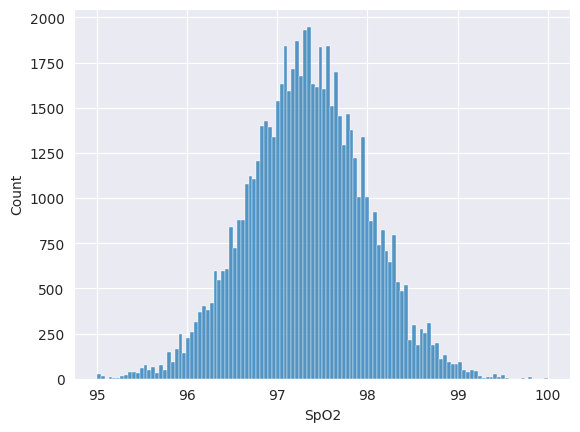

In [871]:
sns.histplot(df['SpO2'])

In [872]:
#due to the findings in the previous cell, we found out the merging of the tables reshaped the distribution of the data into not so normally distributed, this however could be fixed by performing the tests on the observation_df (non merged table).
g1 = observation_df[observation_df['oximetry'] == 1]['SpO₂']
g0 = observation_df[observation_df['oximetry'] == 0]['SpO₂']

#we need to set sample to max 5000 so the data are in range of the recommended sample value
sample_g1 = g1.sample(3000, random_state=42)
sample_g0= g0.sample(3000, random_state=42)

#doing the shapiro test -> pvalue for both values
p1 = shapiro(sample_g1).pvalue
p0 = shapiro(sample_g0).pvalue
print('shapiro:', p1, p0)
#after performing the shapiro test we can see that the p values from both the grous are larger than 0.05 which proves that the normal distribution is present which leads us to perform the levene and t test

shapiro: 0.10880973933264598 0.6169824476877354


<Axes: xlabel='SpO₂', ylabel='Count'>

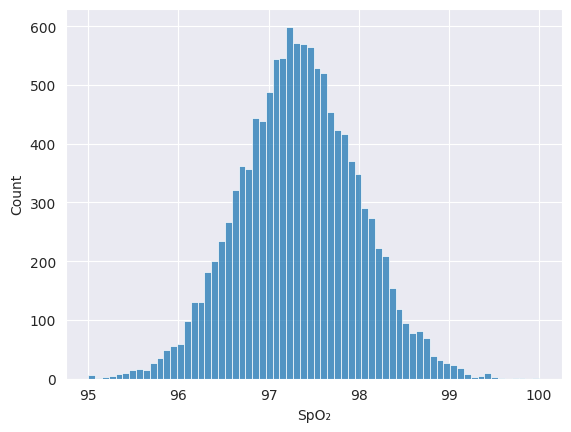

In [873]:
sns.histplot(observation_df['SpO₂'])

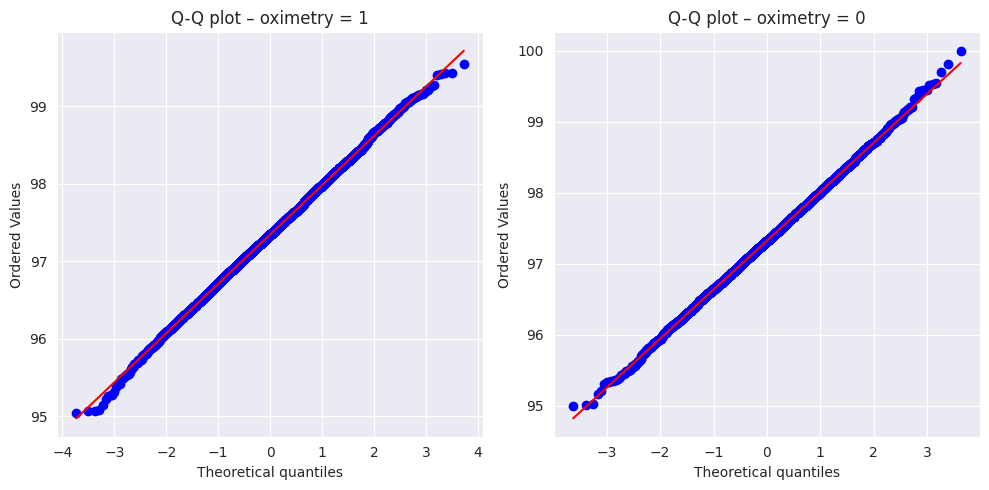

In [874]:
#lets verify the distributions of both the subsets via qqplot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

stats.probplot(g1, dist="norm", plot=ax[0])
ax[0].set_title("Q-Q plot – oximetry = 1")

stats.probplot(g0, dist="norm", plot=ax[1])
ax[1].set_title("Q-Q plot – oximetry = 0")

plt.tight_layout()
plt.show()
#they indeed are

In [875]:
#levenne tests, this whole block is executed since the data are normally distributed
p_lev = stats.levene(sample_g1,sample_g0).pvalue
print('levene:', p_lev)

if p_lev > 0.05:
    # since the variance is the same we can perfrom the usual t-test
    t, p = stats.ttest_ind(sample_g1, sample_g0)
    print('t-test', t, p)
else:
    # variances differ, use Welch's t-test - we know this wasnt in our class notebooks, but we needed to find out if the two groups differ even though they have different variance, so we found this method
    t, p = stats.ttest_ind(sample_g1, sample_g0, equal_var=False)
    print('Welch t-test (unequal variances):', t, p)

levene: 1.253188761462382e-05
Welch t-test (unequal variances): 0.09803193034222664 0.9219102349142181


In [876]:
# Both groups are normally distributed (Shapiro > 0.05), but their variances differ (Levene < 0.05). The Mann–Whitney U test (p = 0.0984 > 0.05) shows no statistically significant difference in SpO₂ levels between oximetry = 0 and oximetry = 1.

### A) Hypothesis 2 - Comparison of Hemoglobin (Hb) Levels Between Oximetry Groups

#### H₀ (Null Hypothesis):
The mean hemoglobin (Hb) level is the same for both groups — patients with oximetry = 0 and oximetry = 1.

#### H₁ (Alternative Hypothesis):
The mean hemoglobin (Hb) level differs between the groups — patients with oximetry = 0 and oximetry = 1.

<Axes: xlabel='Hb level', ylabel='Count'>

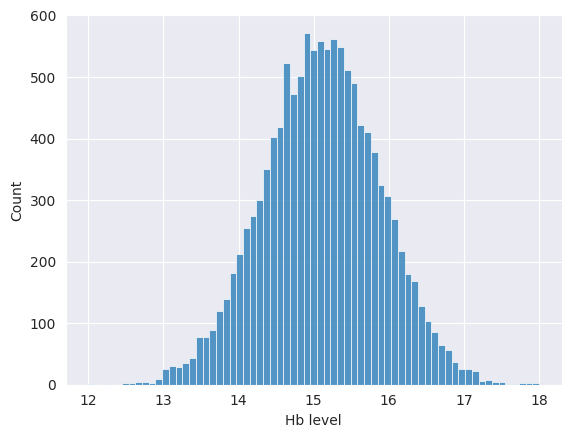

In [877]:
sns.histplot(observation_df['Hb level'])

In [878]:
hb0 = observation_df[observation_df['oximetry'] == 0]['Hb level']
hb1 = observation_df[observation_df['oximetry'] == 1]['Hb level']

#we need to set sample to max 5000 so the data are in range of the recommended sample value
sample_hb0= hb0.sample(2000, random_state=42)
sample_hb1 = hb1.sample(2000, random_state=42)

#doing the shapiro test -> pvalue for both values
p0 = shapiro(sample_hb0).pvalue
p1 = shapiro(sample_hb1).pvalue
print('shapiro:\np0:{} \np1:{}'.format(p0,p1))

shapiro:
p0:0.11878125043102106 
p1:0.85391674151546


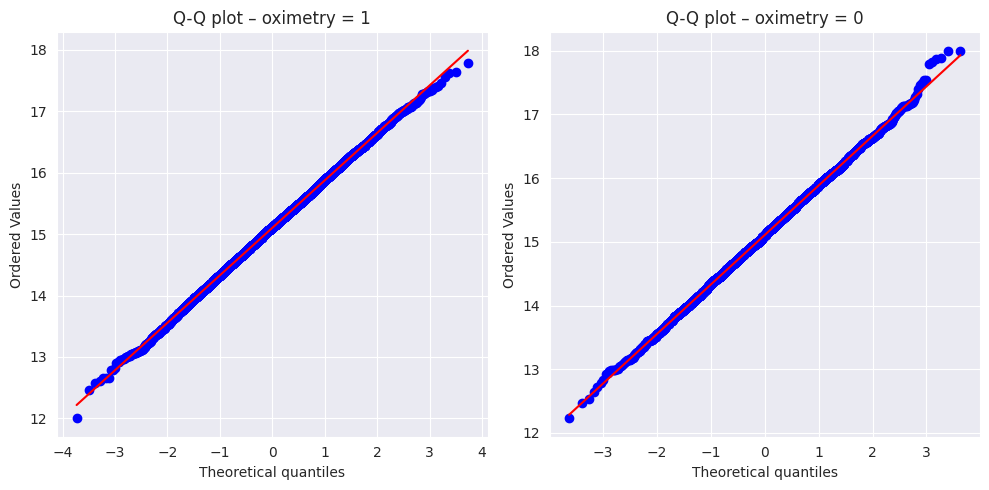

In [879]:
#lets verify the distributions of both the subsets via qqplot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

stats.probplot(hb1, dist="norm", plot=ax[0])
ax[0].set_title("Q-Q plot – oximetry = 1")

stats.probplot(hb0, dist="norm", plot=ax[1])
ax[1].set_title("Q-Q plot – oximetry = 0")

plt.tight_layout()
plt.show()
#they indeed are

In [880]:
#same as H0
p_lev = stats.levene(sample_hb1,sample_hb0).pvalue
print('levene:', p_lev)

if p_lev > 0.05:
    # this was explained in H0
    t, p = stats.ttest_ind(sample_hb1, sample_hb0)
    print('t-test ', t, p)
else:
    # this was explained in H0
    t, p = stats.ttest_ind(sample_hb1, sample_hb0, equal_var=False)
    print('Welch t-test (unequal variances):', t, p)


levene: 0.6624508281537517
t-test  -1.588383168023951 0.11227879476272101


In [881]:
# Both groups are normally distributed (Shapiro > 0.05), with their variance being very similar as well. Students t test shows that the difference of the means was not statistically significant.

### B) Overte či Vaše štatistické testy majú dostatok podpory z dát, teda či majú dostatočne silnú štatistickú silu.

In [882]:
# SpO2 attribute
y0 = sample_g0.values
y1 = sample_g1.values

# base stats
m0, m1 = np.mean(y0), np.mean(y1)
s0, s1 = np.std(y0, ddof=1), np.std(y1, ddof=1)
n0, n1 = len(y0), len(y1)

# CI
se = np.sqrt(s0**2/n0 + s1**2/n1)
df_temp = (s0**2/n0 + s1**2/n1)**2 / ((s0**4)/((n0**2)*(n0-1)) + (s1**4)/((n1**2)*(n1-1)))
ci = stats.t.interval(0.95, df_temp, loc=(m1 - m0), scale=se)
print(f"95% CI for delta means: {ci[0]:.3f} to {ci[1]:.3f}")
#very little difference -> strong statistical power

95% CI for delta means: -0.032 to 0.035


In [883]:
#Cohen
sp = np.sqrt(((n0 - 1)*s0**2 + (n1 - 1)*s1**2) / (n0 + n1 - 2))
d = (m1 - m0) / sp
print(f"Cohen's d: {d:.3f}")
#almost 0 difference -> strong statistical power

Cohen's d: 0.003


#### CI ranging from -0.032 to 0.035 and cohens'd being 0.003 shows us that there is strong statistical power and that the tests have enough support from the data to be legitimate

In [884]:
# HB level attribute
y0 = sample_hb0.values
y1 = sample_hb1.values

# base stats
m0, m1 = np.mean(y0), np.mean(y1)
s0, s1 = np.std(y0, ddof=1), np.std(y1, ddof=1)
n0, n1 = len(y0), len(y1)

# CI
se = np.sqrt(s0**2/n0 + s1**2/n1)
df_temp = (s0**2/n0 + s1**2/n1)**2 / ((s0**4)/((n0**2)*(n0-1)) + (s1**4)/((n1**2)*(n1-1)))
ci = stats.t.interval(0.95, df_temp, loc=(m1 - m0), scale=se)
print(f"95% CI for delta means: {ci[0]:.3f} to {ci[1]:.3f}")
#same result as with SPO2

95% CI for delta means: -0.087 to 0.009


In [885]:
#Cohen
sp = np.sqrt(((n0 - 1)*s0**2 + (n1 - 1)*s1**2) / (n0 + n1 - 2))
d = (m1 - m0) / sp
print(f"Cohen's d: {d:.3f}")
#almost 0 difference -> strong statistical power

Cohen's d: -0.050


#### CI ranging from -0.087 to 0.009 and cohens'd being -0.050 shows us that there is strong statistical power and that the tests have enough support from the data to be legitimate


# Fáza 2

## 2.1 Realizácia predspracovania dát

### A)

Before doing the magic with spliting data we need to set them up by filtering only atributes we need and are usefull in future analysis

In [886]:
df_2 = df.copy()

# we want to work with the data that has some connectivity to "health" specification not anything like position ...
drop_cols = [c for c in ['user_id','station_ID','latitude','longitude'] if c in df_2.columns]
df_2 = df_2.drop(columns=drop_cols)

df_2 = df_2.drop_duplicates()

In [887]:
target = "oximetry"

#split featires and target
X = df_2.drop(columns=[target])
y = df_2[target]

In [888]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train dataframe:", X_train.shape)
print("Test dataframe:", X_test.shape)
print("Oximetry=1/total for train:", y_train.mean().round(3))
print("Oximetry=1/total for test:", y_test.mean().round(3))
#we can see the division of the original df into train and test subdatasets, we can also see the stratification focused on the oximetry attribute worked


Train dataframe: (41501, 23)
Test dataframe: (10376, 23)
Oximetry=1/total for train: 0.597
Oximetry=1/total for test: 0.597


### B)

In [889]:
X_test.head()

,SpO2,HR,PI,RR,EtCO2,FiO2,PRV,BP,Skin Temperature,Motion/Activity index,...,CO,Blood Flow Index,PPG waveform features,Signal Quality Index,Respiratory effort,O2 extraction ratio,SNR,QoS,code,blood_group
49445,96.601411,80.344377,8.884552,15.344047,38.825321,55.089020,84.643454,105.944792,34.263087,10.094809,...,4.001692,67.333233,38.870747,76.138614,40.726619,0.268550,25.952849,good,AM,AB+
30741,97.993688,83.684406,11.323195,15.208839,41.193087,63.886566,111.221376,106.803949,34.890998,9.349818,...,4.005741,42.993997,33.119117,24.206459,33.059317,0.256908,31.628228,excellent,PH,O-
52230,96.805991,89.893353,7.491702,14.655980,42.801724,62.273550,108.099974,101.153579,36.156039,10.064168,...,4.067662,50.017832,37.370695,59.558249,44.561747,0.210238,28.975340,excellent,AU,O+
50948,97.293984,77.630562,11.833415,16.148954,42.182432,65.501698,130.012206,100.104509,35.036113,8.346491,...,4.000921,49.619197,60.764507,42.742079,46.305055,0.219876,29.580558,maintenance,FR,O+
58059,97.263038,84.972915,10.198301,14.049168,39.057607,59.162991,129.506948,99.689616,36.135584,9.809290,...,4.009634,60.365075,58.944290,55.162309,69.790015,0.245487,22.505126,excellent,IN,A+


In [890]:
X_train.columns

Index(['SpO2', 'HR', 'PI', 'RR', 'EtCO2', 'FiO2', 'PRV', 'BP',
       'Skin Temperature', 'Motion/Activity index', 'PVI', 'Hb level', 'SV',
       'CO', 'Blood Flow Index', 'PPG waveform features',
       'Signal Quality Index', 'Respiratory effort', 'O2 extraction ratio',
       'SNR', 'QoS', 'code', 'blood_group'],
      dtype='object')

In [891]:
print(X_train.dtypes)
#every attribute is either category or float64, however this was not the case when we started working with the dataset, QoS, code and blood group were changed into category datatype in 1.2 A), 3rd cell -> we now have to turn category attributes into numberic attributes

SpO2                      float64
HR                        float64
PI                        float64
RR                        float64
EtCO2                     float64
FiO2                      float64
PRV                       float64
BP                        float64
Skin Temperature          float64
Motion/Activity index     float64
PVI                       float64
Hb level                  float64
SV                        float64
CO                        float64
Blood Flow Index          float64
PPG waveform features     float64
Signal Quality Index      float64
Respiratory effort        float64
O2 extraction ratio       float64
SNR                       float64
QoS                      category
code                     category
blood_group              category
dtype: object


In [892]:
X_train['QoS'].unique()

['good', 'excellent', 'acceptable', 'maintenance']
Categories (4, object): ['acceptable', 'excellent', 'good', 'maintenance']

In [893]:
#It makes sense to use ordinal encoding on QoS, since we can set which is the best(excellent) and which is the worst(maintenece)
qos_order = CategoricalDtype(
    categories=["maintenance", "acceptable", "good", "excellent"],
    ordered=True
)

X_train["QoS"] = X_train["QoS"].astype(qos_order)

X_train["QoS_ord"] = X_train["QoS"].cat.codes
X_train = X_train.drop(columns=["QoS"])

In [894]:
X_train['blood_group'].unique()

['A-', 'B+', 'AB+', 'A+', 'AB-', 'O+', 'O-', 'B-']
Categories (8, object): ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']

In [895]:
X_train = pd.get_dummies(X_train, columns=["blood_group"], prefix="bg")

In [896]:
X_train['code'].unique()

['KR', 'CN', 'BJ', 'AR', 'US', ..., 'EC', 'HK', 'CH', 'MK', 'CF']
Length: 97
Categories (96, object): ['AF', 'AM', 'AO', 'AR', ..., 'VE', 'VN', 'VU', 'ZA']

In [897]:
#we also remember that the code attribute is the only attribute that has a missing value which belonged to Okinawa station, we will simply drop these rows
#I did think about imputing the station with a new code for Japan, but its really only 100 rows and we cant use an imputing strategy that could be later replicated as this is Okinawa only...
X_train = X_train.dropna()

In [898]:
#after further analysis we decided to drop code column alltogether, as the only viable encoding option was frequency encoding but that would eventually make no sense...
#We know we should not change te test dataset in this part but this is not really a preprocessing method
X_train = X_train.drop(columns=["code"])
X_test = X_test.drop(columns=["code"])

In [899]:
print(X_test.dtypes)
#We can see that there are no more non numeric attributes!

SpO2                      float64
HR                        float64
PI                        float64
RR                        float64
EtCO2                     float64
FiO2                      float64
PRV                       float64
BP                        float64
Skin Temperature          float64
Motion/Activity index     float64
PVI                       float64
Hb level                  float64
SV                        float64
CO                        float64
Blood Flow Index          float64
PPG waveform features     float64
Signal Quality Index      float64
Respiratory effort        float64
O2 extraction ratio       float64
SNR                       float64
QoS                      category
blood_group              category
dtype: object


### C)

In [900]:
X_train.dtypes.head(30)

SpO2                     float64
HR                       float64
PI                       float64
RR                       float64
EtCO2                    float64
FiO2                     float64
PRV                      float64
BP                       float64
Skin Temperature         float64
Motion/Activity index    float64
PVI                      float64
Hb level                 float64
SV                       float64
CO                       float64
Blood Flow Index         float64
PPG waveform features    float64
Signal Quality Index     float64
Respiratory effort       float64
O2 extraction ratio      float64
SNR                      float64
QoS_ord                     int8
bg_A+                       bool
bg_A-                       bool
bg_AB+                      bool
bg_AB-                      bool
bg_B+                       bool
bg_B-                       bool
bg_O+                       bool
bg_O-                       bool
dtype: object

In [901]:
num_cols = X_train.select_dtypes(include=["float64", "int64","int8"]).columns.tolist()
num_cols

['SpO2',
 'HR',
 'PI',
 'RR',
 'EtCO2',
 'FiO2',
 'PRV',
 'BP',
 'Skin Temperature',
 'Motion/Activity index',
 'PVI',
 'Hb level',
 'SV',
 'CO',
 'Blood Flow Index',
 'PPG waveform features',
 'Signal Quality Index',
 'Respiratory effort',
 'O2 extraction ratio',
 'SNR',
 'QoS_ord']

In [902]:
# Scaniling #1 - Standart Scaler

std_scaler = StandardScaler()

X_train_std = pd.DataFrame(
    std_scaler.fit_transform(X_train[num_cols]),
    columns=num_cols,
    index=X_train.index
)
# values check
check_means = X_train_std[num_cols].mean().round(3)
check_stds  = X_train_std[num_cols].std(ddof=0).round(3)

print("Means (should be ~0):")
print(check_means.head(10))
print("\nStds (should be ~1):")
print(check_stds.head(10))

Means (should be ~0):
SpO2                     0.0
HR                      -0.0
PI                      -0.0
RR                       0.0
EtCO2                   -0.0
FiO2                    -0.0
PRV                     -0.0
BP                      -0.0
Skin Temperature        -0.0
Motion/Activity index    0.0
dtype: float64

Stds (should be ~1):
SpO2                     1.0
HR                       1.0
PI                       1.0
RR                       1.0
EtCO2                    1.0
FiO2                     1.0
PRV                      1.0
BP                       1.0
Skin Temperature         1.0
Motion/Activity index    1.0
dtype: float64


In [903]:
#Scaling #2 – RobustScaler (outlierproof; median=0, IQR=1)

rob_scaler = RobustScaler(with_centering=True,with_scaling=True)

X_train_robust = pd.DataFrame(
    rob_scaler.fit_transform(X_train[num_cols]),
    columns=num_cols,
    index=X_train.index
)

#check if the values are fine
medians = X_train_robust[num_cols].median().round(3)
q75 = X_train_robust[num_cols].quantile(0.75)
q25 = X_train_robust[num_cols].quantile(0.25)
iqr = (q75 - q25).round(3)

print("Medians (should be ~0):")
print(medians.head(10))
print("\nIQR (should be ~1):")
print(iqr.head(10))

Medians (should be ~0):
SpO2                     0.0
HR                       0.0
PI                       0.0
RR                       0.0
EtCO2                    0.0
FiO2                     0.0
PRV                      0.0
BP                       0.0
Skin Temperature        -0.0
Motion/Activity index    0.0
dtype: float64

IQR (should be ~1):
SpO2                     1.0
HR                       1.0
PI                       1.0
RR                       1.0
EtCO2                    1.0
FiO2                     1.0
PRV                      1.0
BP                       1.0
Skin Temperature         1.0
Motion/Activity index    1.0
dtype: float64


In [904]:
# Transformer #1 PowerTransformer
power_tx = PowerTransformer(method="yeo-johnson", standardize=True)

X_train_power = X_train.copy()
X_train_power[num_cols] = power_tx.fit_transform(X_train[num_cols])

# quick checks
means = X_train_power[num_cols].mean().round(3).head(10)
stds  = X_train_power[num_cols].std(ddof=0).round(3).head(10)

print("PowerTransformer -> means ~0:\n", means)
print("\nPowerTransformer -> stds ~1:\n", stds)

PowerTransformer -> means ~0:
 SpO2                     0.0
HR                      -0.0
PI                      -0.0
RR                      -0.0
EtCO2                   -0.0
FiO2                    -0.0
PRV                      0.0
BP                      -0.0
Skin Temperature         0.0
Motion/Activity index   -0.0
dtype: float64

PowerTransformer -> stds ~1:
 SpO2                     1.0
HR                       1.0
PI                       1.0
RR                       1.0
EtCO2                    1.0
FiO2                     1.0
PRV                      1.0
BP                       1.0
Skin Temperature         1.0
Motion/Activity index    1.0
dtype: float64


In [905]:
nq = min(1000, len(X_train))  # practical cap
quant_tx = QuantileTransformer(
    n_quantiles=nq,
    output_distribution="normal",
    random_state=42
)

X_train_quant = X_train.copy()
X_train_quant[num_cols] = quant_tx.fit_transform(X_train[num_cols])

# quick checks
means_q = X_train_quant[num_cols].mean().round(3).head(10)
stds_q  = X_train_quant[num_cols].std(ddof=0).round(3).head(10)

print("QuantileTransformer -> means ~0:\n", means_q)
print("\nQuantileTransformer -> stds ~1:\n", stds_q)

QuantileTransformer -> means ~0:
 SpO2                     0.021
HR                      -0.002
PI                      -0.001
RR                      -0.007
EtCO2                    0.007
FiO2                    -0.002
PRV                      0.009
BP                      -0.005
Skin Temperature        -0.006
Motion/Activity index   -0.005
dtype: float64

QuantileTransformer -> stds ~1:
 SpO2                     0.998
HR                       1.003
PI                       1.003
RR                       0.999
EtCO2                    0.998
FiO2                     0.997
PRV                      1.002
BP                       0.998
Skin Temperature         1.015
Motion/Activity index    1.000
dtype: float64


In [906]:
# we already did more techniques such as Outlier ( winsortizatoin , IQR ) , encoding


### D)


As part of data preprocessing (section 2.1(C)), four commonly used transformation
methods were applied to numerical attributes — two **scaling** and two **distribution
transformation** techniques.

#### Scaling techniques
1. **StandardScaler**
   - Chosen as the baseline normalization method.
   - Scales each feature to have mean ≈ 0 and standard deviation ≈ 1.
   - Improves model convergence and training stability for algorithms sensitive to
     feature magnitude (e.g., Logistic Regression, SVM).

2. **RobustScaler**
   - Used as a more resilient alternative to handle outliers.
   - Scales data using the median and interquartile range (IQR),
     reducing the influence of extreme values (e.g., in the `CO` feature).

#### Transformation techniques
3. **PowerTransformer (Yeo–Johnson)**
   - Applied to stabilize variance and reduce skewness in feature distributions.
   - Helps make distributions more symmetric and supports linear model assumptions.

4. **QuantileTransformer (normal)**
   - Maps the feature quantiles to a normal distribution, effectively reducing the
     impact of outliers and non-Gaussian shapes.
   - Useful for attributes with irregular or multimodal distributions.

#### Summary
These four techniques cover the most relevant preprocessing needs for numerical data:
- **StandardScaler** – baseline normalization,
- **RobustScaler** – robust to outliers,
- **PowerTransformer** – reduces skewness and stabilizes variance,
- **QuantileTransformer** – enforces normal-like distribution.

This combination allows comparison of preprocessing effects in later phases (2.3 and 3),
ensuring a replicable, consistent, and model-friendly data preparation workflow.

## 2.2 Výber atribútov pre strojové učenie

### A)

In [907]:
X = X_train.copy()
y = y_train.copy()

# 1) align indices first (very important if X was dropna'd earlier)
common_idx = X.index.intersection(y.index)
X = X.loc[common_idx]
y = y.loc[common_idx]

# 2) drop rows with any NaN in X (apply the SAME mask to both X and y)
mask = ~X.isna().any(axis=1)
X = X.loc[mask]
y = y.loc[mask]

print("Shapes after align -> X:", X.shape, "| y:", y.shape)

Shapes after align -> X: (41392, 29) | y: (41392,)


In [908]:
scaler_minmax = MinMaxScaler()
X_chi = pd.DataFrame(
    scaler_minmax.fit_transform(X),
    columns=X.columns,
    index=X.index
)
chi_scores, p_values = chi2(X_chi, y)
chi_results = pd.Series(chi_scores, index=X.columns).sort_values(ascending=False)

print("Top 10 features by Chi-Square:\n")
print(chi_results.head(10))

Top 10 features by Chi-Square:

HR                     1164.230502
CO                      435.709035
EtCO2                   305.397141
FiO2                    154.531106
PI                       21.104691
RR                       17.934760
O2 extraction ratio       1.538853
bg_B-                     1.303170
QoS_ord                   1.243664
bg_O+                     1.183909
dtype: float64


In [909]:
X_chi[X_chi.columns]

,SpO2,HR,PI,RR,EtCO2,FiO2,PRV,BP,Skin Temperature,Motion/Activity index,...,SNR,QoS_ord,bg_A+,bg_A-,bg_AB+,bg_AB-,bg_B+,bg_B-,bg_O+,bg_O-
6475,0.525146,0.787473,0.513921,0.715944,0.326645,0.566474,0.530721,0.328978,0.259424,0.548962,...,0.581740,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12274,0.506686,0.857688,0.723126,0.796223,0.532064,0.647200,0.518096,0.263212,0.671844,0.273192,...,0.324382,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
47746,0.386994,0.478045,0.546312,0.553884,0.475704,0.347002,0.626112,0.387173,0.243384,0.378412,...,0.681468,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
56807,0.445673,0.256708,0.625327,0.712715,0.307308,0.588409,0.687110,0.580476,0.379736,0.410406,...,0.342466,0.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46687,0.474444,0.713392,0.461103,0.341468,0.683023,0.541257,0.390535,0.556896,0.454367,0.623607,...,0.524398,0.666667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32793,0.460962,0.548346,0.474521,0.466746,0.580586,0.381199,0.677896,0.406224,0.354757,0.692835,...,0.704693,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
52966,0.264648,0.781487,0.534218,0.640457,0.617411,0.557990,0.635862,0.688202,0.509013,0.420458,...,0.889518,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
26667,0.477546,0.363955,0.680007,0.510529,0.509821,0.361080,0.791034,0.544325,0.440188,0.309792,...,0.316030,0.333333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6446,0.466543,0.523679,0.486441,0.692979,0.301562,0.321686,0.402102,0.436908,0.409603,0.415853,...,0.394871,0.666667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [910]:
X_mi = X.copy()
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_results = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

print("Top 10 features by Mutual Information:\n")
print(mi_results.head(10))

Top 10 features by Mutual Information:

HR                       0.559387
CO                       0.554434
EtCO2                    0.511240
RR                       0.489521
FiO2                     0.484673
PPG waveform features    0.482610
Blood Flow Index         0.482178
PVI                      0.479729
SV                       0.478260
PI                       0.477896
dtype: float64


In [911]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)

rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("Top 10 features by Random Forest Importance:\n")
print(rf_importances.head(10))

Top 10 features by Random Forest Importance:

HR                     0.231946
CO                     0.213686
EtCO2                  0.114698
FiO2                   0.071806
RR                     0.050141
PI                     0.045856
SpO2                   0.032070
SV                     0.019168
O2 extraction ratio    0.019016
Respiratory effort     0.018663
dtype: float64


In [912]:
#compare 3 methods
feature_scores = pd.concat([
    mi_results.rename("Mutual Information"),
    chi_results.rename("Chi2"),
    rf_importances.rename("Random Forest")
], axis=1)

# normalize to 0–1 scale for easier comparison
feature_scores = feature_scores.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# compute average score
feature_scores["Average"] = feature_scores.mean(axis=1)
feature_scores.sort_values("Average", ascending=False).head(10)

,Mutual Information,Chi2,Random Forest,Average
HR,1.000000,1.000000,1.000000,1.000000
CO,0.991147,0.374244,0.921206,0.762199
EtCO2,0.913930,0.262314,0.494068,0.556771
FiO2,0.866436,0.132730,0.308987,0.436051
RR,0.875103,0.015402,0.215498,0.368668
PI,0.854322,0.018125,0.197009,0.356485
SpO2,0.843700,0.000513,0.137522,0.327245
PPG waveform features,0.862748,0.000470,0.077891,0.313703
Blood Flow Index,0.861977,0.000793,0.076666,0.313145
SV,0.854972,0.000000,0.081849,0.312274


<Figure size 1000x600 with 0 Axes>

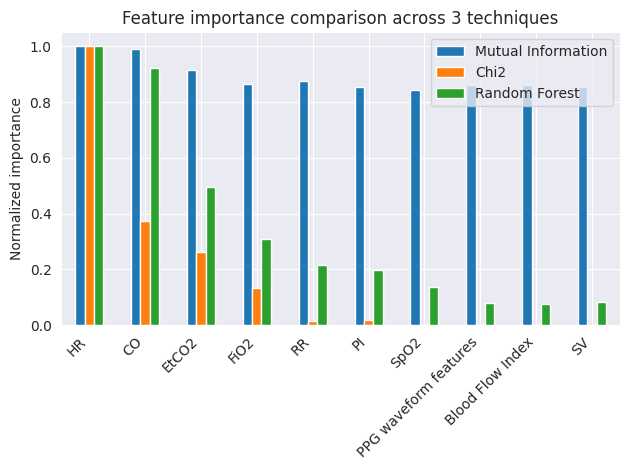

In [913]:
#visualization
top10 = feature_scores.sort_values("Average", ascending=False).head(10)

plt.figure(figsize=(10,6))
top10[["Mutual Information", "Chi2", "Random Forest"]].plot(kind="bar")
plt.title("Feature importance comparison across 3 techniques")
plt.ylabel("Normalized importance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### 4.2.1 A) Findings & decisions (feature selection)

**Setup.** Informativeness of features for the target `oximetry` was evaluated by three
independent methods: (1) Mutual Information (MI), (2) Chi-Square (χ²; after MinMax scaling
to ensure non-negativity), and (3) model-based Random Forest importance. Scores were
normalized to ⟨0,1⟩ and averaged for comparison.

**Consistent signals across methods.**
- **HR** and **CO** ranked **#1–#2** in both MI and Random Forest and stayed on top
  in the averaged ranking → strongest, method-agnostic predictors.
- **EtCO2** and **FiO2** showed **high to medium** importance in MI and RF
  (respiratory physiology) → robust, clinically plausible predictors.
- **RR** and **PI** were **medium**; **SpO2** medium-to-lower (still relevant).
- Other waveform/flow indices (PPG waveform features, Blood Flow Index, SV) were
  **lower**, yet non-zero, suggesting auxiliary value.

**Why χ² looks conservative.**
- χ² assumes independence on **binned/positive** data; with continuous variables
  (scaled to 0–1) it is less sensitive to nuanced, non-linear relations.
- MI and RF capture **non-linear/monotone** effects better, therefore we weigh them
  more when resolving ties.

**Decision – feature shortlist for ML (to carry forward).**
- **Core set (high confidence):** `HR`, `CO`, `EtCO2`, `FiO2`.
- **Support set (keep / test with regularization):** `RR`, `PI`, `SpO2`.
- **Optional (use if helpful in CV, otherwise drop to reduce complexity):**
  `PPG waveform features`, `Blood Flow Index`, `SV`.

**Rationale.**
- Chosen features are consistently ranked by **≥2 methods** and align with earlier EDA
  (HR ↔ oximetry, respiratory parameters ↔ oxygenation).
- Keeping a compact core reduces multicollinearity and speeds training; the support/optional
  groups allow controlled expansion if cross-validated performance improves.

**Next steps (planned in 2.2/2.3).**
- Compare *Core* vs. *Core+Support* (and optionally +PCA) in stratified CV with the
  final preprocessing choice (scaling/transformers).
- Use model regularization (e.g., L1/L2) or tree-based models to manage redundancy.


### C) Findings & decisions (feature selection)

**Setup.** Informativeness of features for the target `oximetry` was evaluated by three
independent methods: (1) Mutual Information (MI), (2) Chi-Square (χ²; after MinMax scaling
to ensure non-negativity), and (3) model-based Random Forest importance. Scores were
normalized to ⟨0,1⟩ and averaged for comparison.

**Consistent signals across methods.**
- **HR** and **CO** ranked **#1–#2** in both MI and Random Forest and stayed on top
  in the averaged ranking → strongest, method-agnostic predictors.
- **EtCO2** and **FiO2** showed **high to medium** importance in MI and RF
  (respiratory physiology) → robust, clinically plausible predictors.
- **RR** and **PI** were **medium**; **SpO2** medium-to-lower (still relevant).
- Other waveform/flow indices (PPG waveform features, Blood Flow Index, SV) were
  **lower**, yet non-zero, suggesting auxiliary value.

**Why χ² looks conservative.**
- χ² assumes independence on **binned/positive** data; with continuous variables
  (scaled to 0–1) it is less sensitive to nuanced, non-linear relations.
- MI and RF capture **non-linear/monotone** effects better, therefore we weigh them
  more when resolving ties.

**Decision – feature shortlist for ML (to carry forward).**
- **Core set (high confidence):** `HR`, `CO`, `EtCO2`, `FiO2`.
- **Support set (keep / test with regularization):** `RR`, `PI`, `SpO2`.
- **Optional (use if helpful in CV, otherwise drop to reduce complexity):**
  `PPG waveform features`, `Blood Flow Index`, `SV`.

**Rationale.**
- Chosen features are consistently ranked by **≥2 methods** and align with earlier EDA
  (HR ↔ oximetry, respiratory parameters ↔ oxygenation).
- Keeping a compact core reduces multicollinearity and speeds training; the support/optional
  groups allow controlled expansion if cross-validated performance improves.

**Next steps (planned in 2.2/2.3).**
- Compare *Core* vs. *Core+Support* (and optionally +PCA) in stratified CV with the
  final preprocessing choice (scaling/transformers).
- Use model regularization (e.g., L1/L2) or tree-based models to manage redundancy.


## 2.3 Replikovateľnosť predspracovania

### A)

In [919]:
# target and schema
TARGET = "oximetry"
QOS_CATEGORIES = [["maintenance", "acceptable", "good", "excellent"]]  # fixed order

# columns present in X_train / X_test now
all_cols = X_train.columns.tolist()

# which columns to treat as categorical vs numeric at this stage
cat_cols = [c for c in all_cols if c in ["QoS", "blood_group"]]
num_cols = [c for c in all_cols if c not in cat_cols]

# optional: drop 'code' if it accidentally appears later
drop_if_present = ["code"]


In [920]:

from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


def build_preprocessor(variant: str = "standard") -> ColumnTransformer:
    # numeric pipeline by variant
    if variant == "standard":
        num_pipe = Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler()),
        ])
    elif variant == "robust":
        num_pipe = Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("scale", RobustScaler(with_centering=True, with_scaling=True)),
        ])
    elif variant == "power":
        num_pipe = Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler()),
            ("power", PowerTransformer(method="yeo-johnson", standardize=False)),
        ])
    elif variant == "quantile":
        num_pipe = Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("scale", RobustScaler(with_centering=True, with_scaling=True)),
            ("quant", QuantileTransformer(output_distribution="normal", random_state=42)),
        ])
        # QuantileTransformer will auto cap n_quantiles appropriately
    else:
        raise ValueError("Unknown variant")

    # categorical pipelines
    qos_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ord", OrdinalEncoder(categories=QOS_CATEGORIES, handle_unknown="use_encoded_value", unknown_value=-1)),
    ])
    bg_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ])

    # construct ColumnTransformer
    transformers = []
    if num_cols:
        transformers.append(("num", num_pipe, num_cols))
    if "QoS" in cat_cols:
        transformers.append(("qos", qos_pipe, ["QoS"]))
    if "blood_group" in cat_cols:
        transformers.append(("bg", bg_pipe, ["blood_group"]))

    pre = ColumnTransformer(
        transformers=transformers,
        remainder="drop"  # keep only specified columns in the exact order
    )
    return pre


In [921]:
# choose one of your four variants here
VARIANT = "robust"  # options: "standard", "robust", "power", "quantile"

# start from clean copies
Xtr = X_train.drop(columns=[c for c in drop_if_present if c in X_train.columns]).copy()
Xte = X_test.drop(columns=[c for c in drop_if_present if c in X_test.columns]).copy()
ytr = y_train.copy()
yte = y_test.copy()

# build and fit preprocessor on TRAIN ONLY
pre = build_preprocessor(VARIANT)
Xtr_prep = pre.fit_transform(Xtr, ytr)

# transform TEST with the same fitted preprocessor (no refit)
Xte_prep = pre.transform(Xte)

print("Shapes -> X_train_prep:", Xtr_prep.shape, "| X_test_prep:", Xte_prep.shape)

# optional: get feature names after transformation
try:
    feat_names = pre.get_feature_names_out()
    print("Prepared feature count:", len(feat_names))
    print("First 10 features:", feat_names[:10])
except Exception:
    pass

# save the fitted preprocessor for later phases (2.3 / 3.x)
joblib.dump(pre, f"preprocessor_{VARIANT}.joblib")
print(f"Saved preprocessor_{VARIANT}.joblib")


TypeError: OrdinalEncoder.__init__() got an unexpected keyword argument 'categories'

### B)